In [4]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, DateType
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import (
accuracy_score, precision_score, recall_score, f1_score,
roc_auc_score, average_precision_score, confusion_matrix, log_loss, classification_report, precision_recall_curve
)
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import pickle

# Configuração do Spark
spark = (
    SparkSession.builder
    .appName("Spark Session")
    .getOrCreate()
)
spark

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# spark.sparkContext.setLogLevel("ERROR")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Extração dos dados e análise exploratória
- Loading dos arquivos parquet, referente as bases de dados do problema
- Base de transações, membros e logs
- Entendimento dos dados disponiveis

In [ ]:
# Loading das bases de dados
df_transactions = spark.read.parquet("/content/drive/MyDrive/Data Master/transactions.parquet")
df_members = spark.read.parquet("/content/drive/MyDrive/Data Master/members.parquet")
df_logs = spark.read.parquet("/content/drive/MyDrive/Data Master/user_logs.parquet")

### Base de transações

In [ ]:
# Transformação das colunas de data
df_transactions = df_transactions.select(
    F.col('msno'),
    F.col('payment_method_id').cast(DoubleType()),
    F.col('payment_plan_days').cast(DoubleType()),
    F.col('plan_list_price').cast(DoubleType()),
    F.col('actual_amount_paid').cast(DoubleType()),
    F.col('is_auto_renew').cast(IntegerType()),
    F.col('transaction_date'),
    F.col('membership_expire_date'),
    F.col('is_cancel').cast(IntegerType()),
    F.col('safra')
).withColumn(
    'transaction_date',
    F.to_date(F.concat(
                F.col('transaction_date').substr(1, 4),
                F.lit('-'),
                F.col('transaction_date').substr(5, 2),
                F.lit('-'),
                F.col('transaction_date').substr(7, 2)), 'yyyy-MM-dd')
).withColumn(
    'membership_expire_date',
    F.to_date(F.concat(
                F.col('membership_expire_date').substr(1, 4),
                F.lit('-'),
                F.col('membership_expire_date').substr(5, 2),
                F.lit('-'),
                F.col('membership_expire_date').substr(7, 2)), 'yyyy-MM-dd')
).withColumn(
    'safra',
    F.to_date(
        F.concat(
            F.col('safra').substr(1, 4),
            F.lit('-'),
            F.col('safra').substr(5, 2),
            F.lit('-'),
            F.lit('01')), 'yyyy-MM-dd')
)

### Base de membros

In [ ]:
df_members = df_members.select(
    F.col('msno'),
    F.col('city').cast(IntegerType()),
    F.col('bd').cast(IntegerType()),
    F.col('gender'),
    F.col('registered_via').cast(IntegerType()),
    F.col('registration_init_time'),
    F.col('is_ativo').cast(IntegerType()),
    F.col('safra')
).withColumn(
    'safra',
    F.to_date(
        F.concat(
            F.col('safra').substr(1, 4),
            F.lit('-'),
            F.col('safra').substr(5, 2),
            F.lit('-'),
            F.lit('01')), 'yyyy-MM-dd')
).withColumn(
    'registration_init_time',
    F.to_date(
        F.concat(
            F.col('registration_init_time').substr(1, 4),
            F.lit('-'),
            F.col('registration_init_time').substr(5, 2),
            F.lit('-'),
            F.col('registration_init_time').substr(7, 2)), 'yyyy-MM-dd')
)

### Base logs

In [ ]:
df_logs = df_logs.select(
    F.col('msno'),
    F.col('num_25').cast(DoubleType()),
    F.col('num_50').cast(DoubleType()),
    F.col('num_75').cast(DoubleType()),
    F.col('num_985').cast(DoubleType()),
    F.col('num_100').cast(DoubleType()),
    F.col('num_unq').cast(DoubleType()),
    F.col('total_secs').cast(DoubleType()),
    F.col('safra')
).withColumn(
    'safra',
    F.to_date(
        F.concat(
            F.col('safra').substr(1, 4),
            F.lit('-'),
            F.col('safra').substr(5, 2),
            F.lit('-'),
            F.lit('01')), 'yyyy-MM-dd')
)

# O Case
Dados históricos de dois anos de clientes de uma empresa que oferece streaming de musica baseado em assinatura.
Quando os usuários se inscrevem no serviço, eles podem optar por renovar o serviço manualmente ou renovar automaticamente, podendo cancelar ativamente sua associação à qualquer momento.
## Modelo de Churn
Criação de um modelo classificador para prever clientes que serão churn 3 meses no futuro (ou seja, clientes que possuem assinatura ativa no periodo analisado e 3 mses depois desse período ele não esta mais ativo, ou porque cancelou ou não renovou a assinatura) e identifique os clientes que serão direcionados para a ação de forma proativa.

# Definição de público
- Clientes que possuem assinatura ativa, utilizando a base de membros
- Como a base apresenta safras de todos os meses ao longo de 2016, utiliza-se o público até a safra de 2016-09-01 para que possuam apenas clientes que possamos saber o comportamento 3 meses para a frente

In [ ]:
spine = df_members.filter(
    (F.col('is_ativo') == 1) &
    (F.col('safra') <= F.lit('2016-09-01'))
).dropDuplicates()

# Definição da target
- Churn ou não churns, 3 meses no futuro
- Todas as variaveis sobre o cliente, estão em uma visao 3 meses antes da target
- A partir da spine, com os clientes ativos em cada safra, é feito um cruzamento buscando o cliente na safra 3 meses para o futuro
- Cria-se a variável target, 1 se o cliente estiver ativo, 0 se nao estiver ativo (churn)

In [ ]:
df_members_aliased = df_members.select('msno', 'safra', 'is_ativo').withColumnRenamed('safra', 'safra_target').withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra_target')))
df = spine.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.add_months(F.col('safra'), 3)))
df = df.join(df_members_aliased.select(
    'chave','safra_target', 'is_ativo'
    ).withColumn(
    'target', F.when(F.col('is_ativo') == 1, 0).otherwise(1)
    ).drop('is_ativo'),on='chave', how='left').drop('chave')

**Amostra**

Como se trata de uma base muito extensa, optou-se por realizar uma amostra estratificada utilizando 10% da base, para que garantir que se manter as proporções da target da população.

In [ ]:
# Obtendo uma amostra, mantendo a proporção da target
fractions = {0: 0.2, 1: 0.2}  # Proporção de amostragem para cada classe

df_sample = df.sampleBy("target", fractions, seed=42)

#### *Considerações sobre público e a target*

1.   *Target desbalanceada* -> Há uma quantidade bem maior de clientes que continuaram ativos (1), que os clientes churn. Dessa forma, na hora de criar o modelo, é interessante utilizar pesos para balancear a target.
2.   *Mesmo cliente pode aparecer mais de uma vez na base* -> estamos capturando o comportamente desse cliente no mes, é necessário trazer as features sobre a transação e logs, mostrando o comportamento diferente em cada mes, e como isso impacta na target (se ele será churn ou não)
3.   *Horizonte do público em 2016* -> a target deve ser o cliente ativo ou nao, informação que é possivel de encontrar apenas na base de members, e portanto, temos apenas informações de 2016


# Adição das informações de transações e logs

#### **Transações:**

*variaveis uteis existentes:*
- is_auto_renew -> seria um indicativo de que o cliente talvez nao renove o plano?
- payment_plan_days -> indicando quanto tempo o cliente tem para renovar o plano
- plan_list_price -> indicando o valor tabelado da assinatura
- actual_amount_paid -> mostrando o quanto o cliente esta pagando, se for muito pode trazer indicios de cancelamento
- membership_expire_date -> transformar em quanto tempo para finalização do plano
- is_canceled -> indicando se o plano foi cancelado ou nao -> pode indicar que o cliente cancelou e no mes seguinte a assinatura nao estara mais ativa



In [ ]:
transactions=df_transactions.filter(F.year(F.col('safra'))=='2016')

In [ ]:
transactions.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra'))).groupBy('chave').count().orderBy(F.desc('count')).show(5)

_Apenas uma transação mensal_

In [ ]:
df_sample = df_sample.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra')))
df_sample = df_sample.join(transactions.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra'))).select('chave', 'is_auto_renew', 'payment_plan_days', 'plan_list_price','actual_amount_paid', 'membership_expire_date', 'is_cancel'),
                     on='chave', how='left')

#### **Logs:**
Utilizar a ultima data do mês para buscar as estatisticas sobre o uso, porque dessa forma é possível compreender como foi o comportamento do cliente ao longo do mês com o uso da plataforma.

*variáveis:*
1. num_25
2. num_50
3. num_75
4. num_985
5. num_100
6. num_unq
7. total_secs

In [ ]:
logs=df_logs.filter(F.year(F.col('safra'))=='2016')

In [ ]:
logs.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra'))).groupBy('chave').count().orderBy(F.desc('count')).show(5)

_Apenas uma informação de log mensal_

In [ ]:
df_sample = df_sample.join(logs.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra'))).select('chave', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs'),
                     on='chave', how='left')

In [ ]:
# Salvando a amostra em formato CSV
output_csv_path = "dados/amostra.csv"
df_sample.toPandas().to_csv(output_csv_path, index=False)

# Análise da target
- Distribuição da target na amostra selecionada
- Analise da target ao longo das safras

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Data Master/dados/amostra.csv")

<ipython-input-231-82669921>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=data, palette=["#000000A6", "#970000AA"])


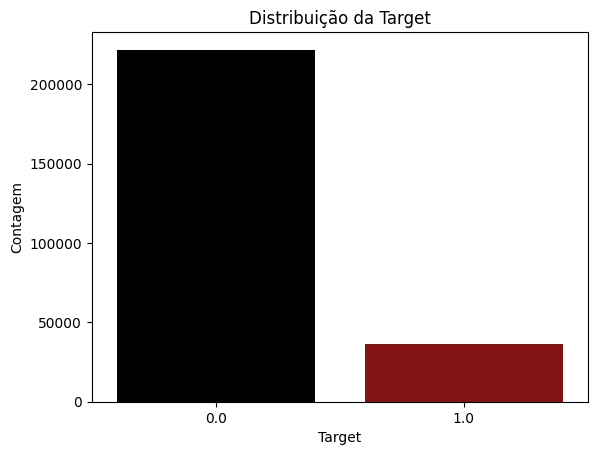

In [ ]:
# Distribuição da target
sns.countplot(x='target', data=data, palette=["#000000A6", "#970000AA"])
plt.title('Distribuição da Target')
plt.xlabel('Target')
plt.ylabel('Contagem')
plt.show()

In [ ]:
percentual_churn = data.groupby('safra')['target'].mean().reset_index()
percentual_churn.columns = ['safra', 'percentual_churn']
percentual_churn['percentual_churn'] = round(percentual_churn['percentual_churn'] * 100, 2)
mean_churn = percentual_churn['percentual_churn'].mean()

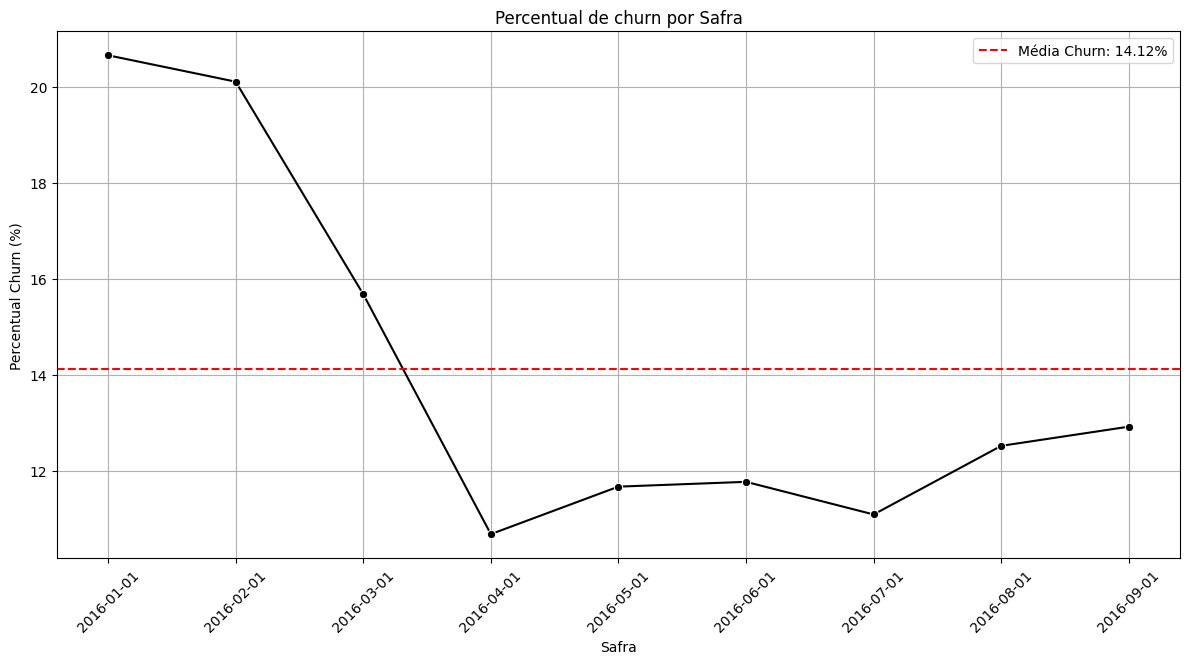

In [ ]:
# Analise temporal da variável target
plt.figure(figsize=(12, 6))
sns.lineplot(data=percentual_churn,x='safra', y='percentual_churn', marker='o', color="#000000")
plt.axhline(mean_churn, color='red', linestyle='--', label=f'Média Churn: {mean_churn:.2f}%')
plt.legend()
plt.grid()
plt.tight_layout()
plt.xlabel('Safra')
plt.ylabel('Percentual Churn (%)')
plt.title('Percentual de churn por Safra')
plt.xticks(rotation=45)
plt.show()

# Analise das variáveis e data-prep
















## Separação das bases de treino, teste, validação e oot
- Não serão utilizadas as safras 2016-01-01, 2016-02-01 e 2016-03-01 para o desenvolvimento do modelo, por apresentarem alto percentual de churn, destoando dos outros meses
- **Treino e teste**: 90% treino e teste, utilizando as safras de 2016-03-01 á 2016-08-01, separados depois em 80% pra treino e 20% teste
- **Validacao**: 10% da base, utilizando as safras de 2016-03-01 á 2016-08-01
- **OOT**: 100% da base na safra em 2016-09-01

In [ ]:
data.groupby('safra').count()['msno']

,msno
safra,
2016-01-01,28398
2016-02-01,29156
2016-03-01,27373
2016-04-01,26237
2016-05-01,27194
2016-06-01,26564
2016-07-01,30556
2016-08-01,31264
2016-09-01,31468


In [ ]:
amostra_treino_validacao = (data.loc[data["safra"].isin(["2016-04-01", "2016-05-01", "2016-06-01", "2016-07-01", "2016-08-01"])][["msno"]].drop_duplicates().sample(frac = 0.8, random_state = 42, replace = False))

train = (amostra_treino_validacao.sample(frac = 0.9, random_state = 42, replace = False)[["msno"]].drop_duplicates())

valid = (amostra_treino_validacao.loc[~amostra_treino_validacao["msno"].isin(list(train["msno"].unique()))][["msno"]].drop_duplicates())

test = (data.loc[
            (data["safra"].isin(["2016-04-01", "2016-05-01", "2016-06-01", "2016-07-01", "2016-08-01"])) &
            (~data["msno"].isin(list(train["msno"].unique()))) &
            (~data["msno"].isin(list(valid["msno"].unique())))][["msno"]].drop_duplicates()
)

oot = (data.loc[(data["safra"].isin(["2016-09-01"]))][["msno"]].drop_duplicates())

train = train.merge(data.loc[data["safra"].isin(["2016-04-01", "2016-05-01", "2016-06-01", "2016-07-01", "2016-08-01"])], on = "msno", how = "left")
valid = valid.merge(data.loc[data["safra"].isin(["2016-04-01", "2016-05-01", "2016-06-01", "2016-07-01", "2016-08-01"])], on = "msno", how = "left")
test = test.merge(data.loc[data["safra"].isin(["2016-04-01", "2016-05-01", "2016-06-01", "2016-07-01", "2016-08-01"])], on = "msno", how = "left")
oot = oot.merge(data.loc[data["safra"].isin(["2016-09-01"])], on = "msno", how = "left")

In [ ]:
print('Total treino: ', train.count()['msno'])
print('Total teste: ', test.count()['msno'])
print('Total validação: ', valid.count()['msno'])
print('Total OOT: ', oot.count()['msno'])

Total treino:  102161
Total teste:  28318
Total validação:  11336
Total OOT:  31468


<ipython-input-237-2384464509>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data_plot, x='target', y='perc', label=name, palette=custom_palette)


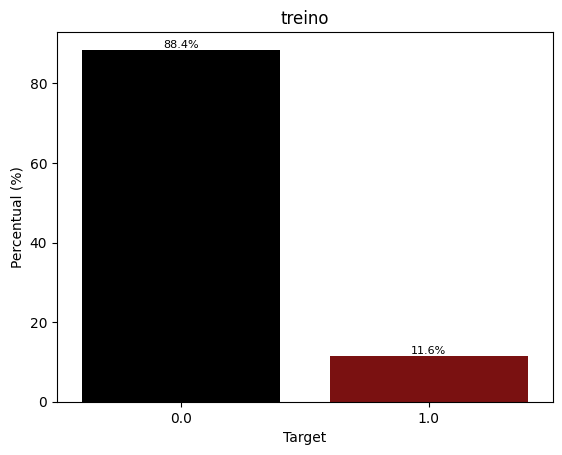

<ipython-input-237-2384464509>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data_plot, x='target', y='perc', label=name, palette=custom_palette)


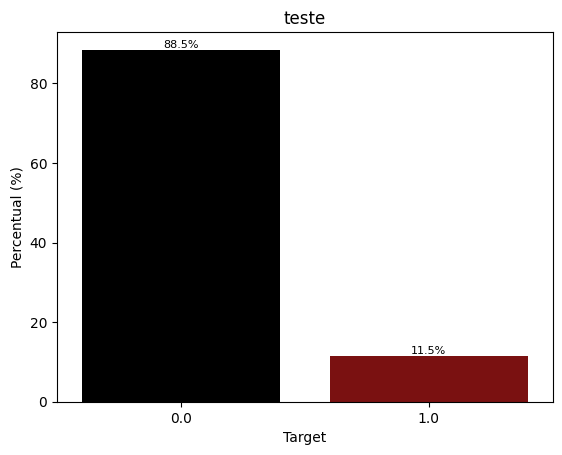

<ipython-input-237-2384464509>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data_plot, x='target', y='perc', label=name, palette=custom_palette)


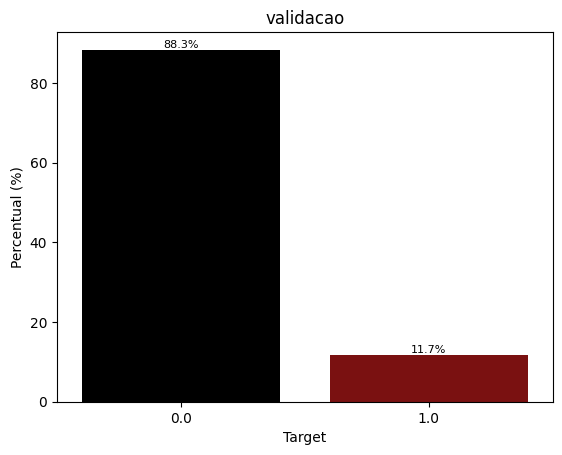

<ipython-input-237-2384464509>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data_plot, x='target', y='perc', label=name, palette=custom_palette)


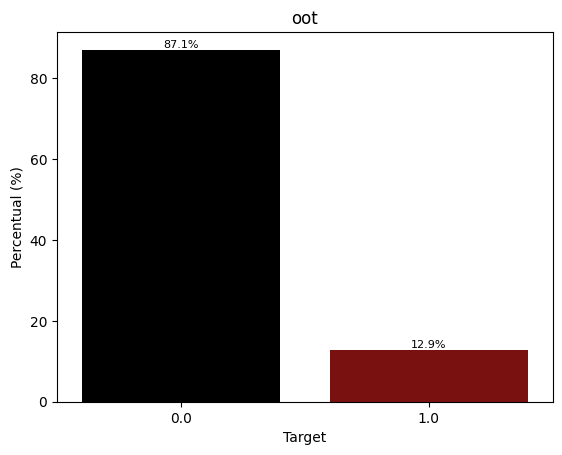

In [ ]:
def contagem(df):
    return df.groupby('target', as_index=False).count().rename(columns={'msno': 'count'}).assign(perc=lambda x: x['count'] / x['count'].sum() * 100)

def plot_churn(df, name):
    custom_palette = ["#000000", "#8B0000"]
    data_plot = contagem(df)
    ax = sns.barplot(data=data_plot, x='target', y='perc', label=name, palette=custom_palette)
    plt.xlabel('Target')
    plt.ylabel('Percentual (%)')
    plt.title(name)

    # Adiciona o rótulo em cada barra
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.1f}%',
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=8, color='black')

    plt.show()

plot_churn(train, 'treino')
plot_churn(test, 'teste')
plot_churn(valid, 'validacao')
plot_churn(oot, 'oot')


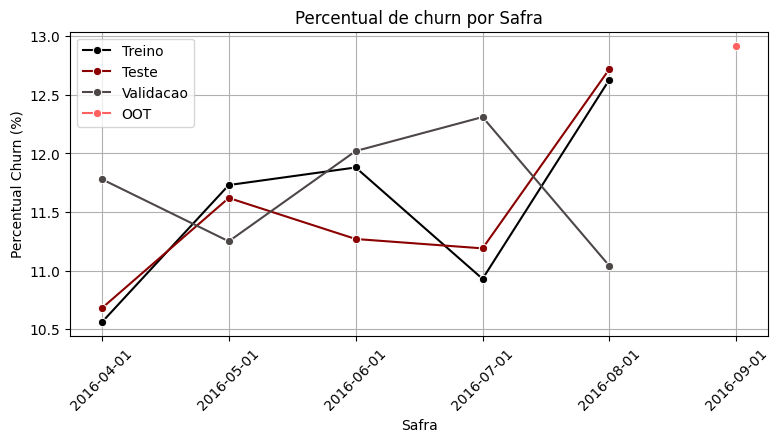

In [ ]:
def perc_churn(df, name):
    """
    Função para calcular o percentual de churn em um DataFrame.
    """
    aux = df.groupby('safra')['target'].mean().reset_index()
    aux.columns = ['safra', f'percentual_churn_{name}']
    aux[f'percentual_churn_{name}'] = round(aux[f'percentual_churn_{name}'] * 100, 2)
    return aux

# Calculando o percentual de churn para cada conjunto de dados
train_churn = perc_churn(train, 'treino')
test_churn = perc_churn(test, 'teste')
valid_churn = perc_churn(valid, 'validacao')
oot_churn = perc_churn(oot, 'oot')

# Analise temporal da variável target
plt.figure(figsize=(8, 4))
sns.lineplot(data=train_churn,x='safra', y='percentual_churn_treino', marker='o', label='Treino', color="#000000")
sns.lineplot(data=test_churn,x='safra', y='percentual_churn_teste', marker='o', label='Teste', color="#8B0000")
sns.lineplot(data=valid_churn,x='safra', y='percentual_churn_validacao', marker='o', label='Validacao', color="#4D4747")
sns.lineplot(data=oot_churn,x='safra', y='percentual_churn_oot', marker='o', label='OOT',   color="#FF6161")
plt.xlabel('Safra')
plt.ylabel('Percentual Churn (%)')
plt.title('Percentual de churn por Safra')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

## Análise das variáveis

**Valores missing**

In [ ]:
null_counts = train.isnull().sum()
null_percent = (null_counts / len(data)) * 100
null_summary = pd.DataFrame({'null_count': null_counts, 'null_percent': null_percent.round(2)})
null_summary

,null_count,null_percent
msno,0,0.00
chave,0,0.00
city,0,0.00
bd,0,0.00
gender,49895,19.32
registered_via,0,0.00
registration_init_time,0,0.00
is_ativo,0,0.00
safra,0,0.00
safra_target,0,0.00


In [ ]:
# Separação das features categorias e numericas
cat_cols = ['city', 'gender', 'registered_via', 'is_auto_renew','is_cancel']
num_cols = ['bd', 'payment_plan_days', 'actual_amount_paid', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']

**Variáveis categóricas**

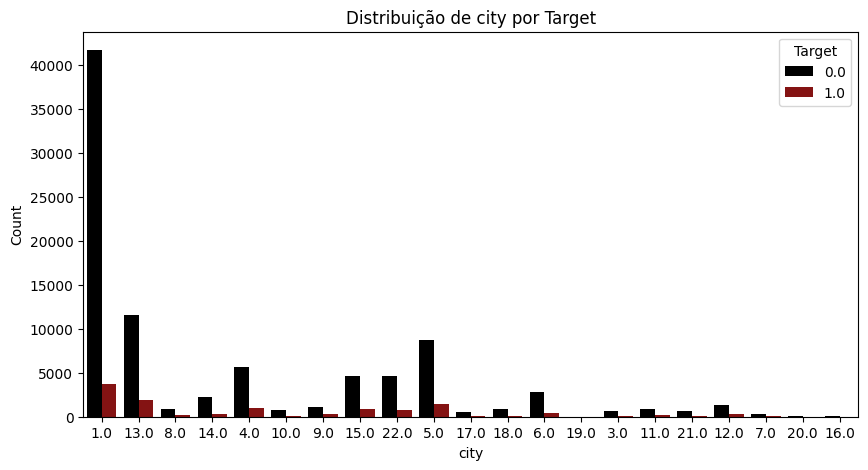

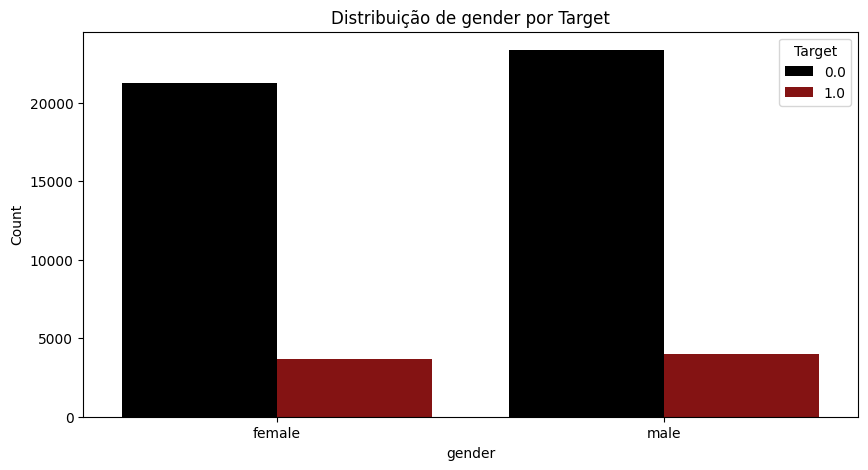

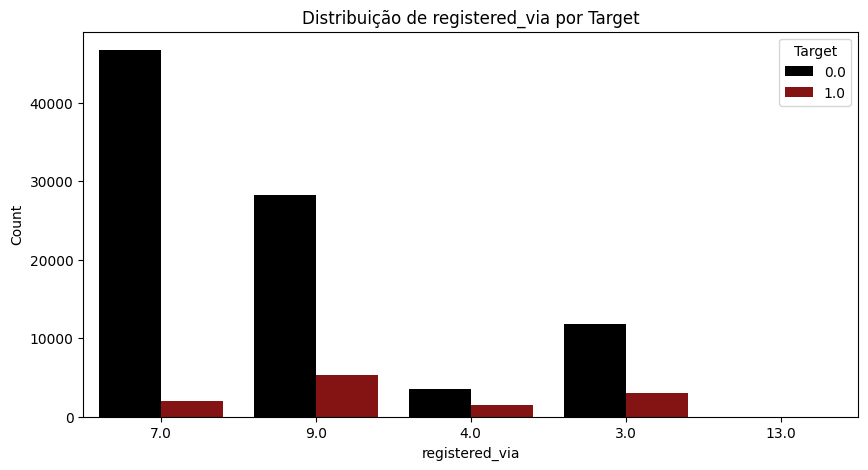

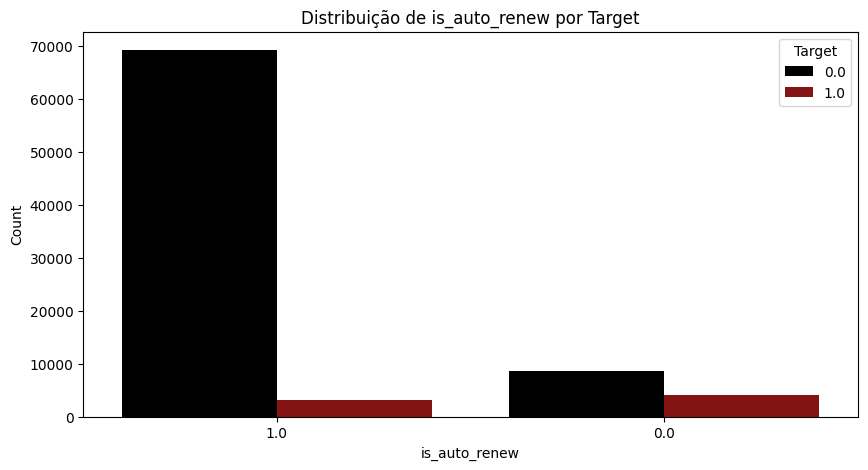

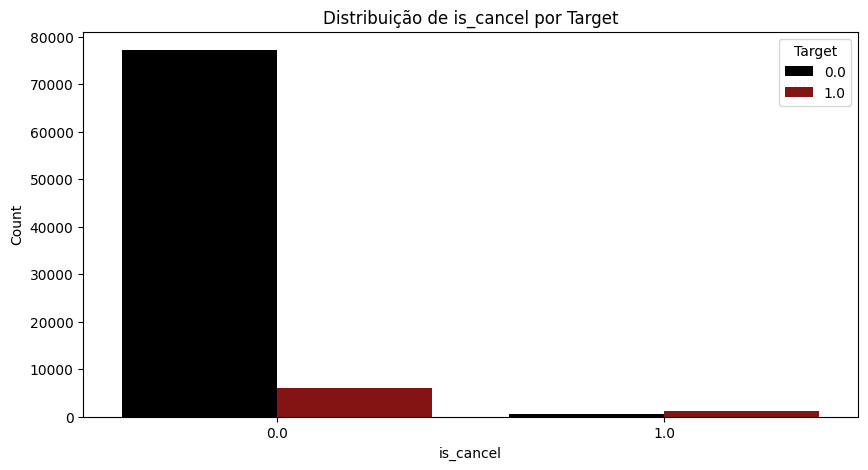

In [ ]:
for i in cat_cols:
  train[i] = train[i].astype('string')
  plt.figure(figsize=(10, 5))
  sns.countplot(data=train, x=i, hue='target', palette=["#000000A6", "#970000AA"])
  plt.title(f'Distribuição de {i} por Target')
  plt.xlabel(i)
  plt.ylabel('Count')
  plt.legend(title='Target', loc='upper right')
  plt.show()

In [ ]:
for i in cat_cols:
    display(train.groupby(i)[['target']].mean().assign(target=lambda x: round(x['target'] * 100, 2)).rename(columns={'target': 'percentual_churn'}).sort_values('percentual_churn', ascending=False).T)

city,9.0,11.0,12.0,20.0,21.0,15.0,22.0,10.0,6.0,4.0,8.0,5.0,13.0,14.0,3.0,17.0,18.0,7.0,16.0,19.0,1.0
percentual_churn,20.82,17.7,16.03,15.73,15.57,15.07,14.68,14.45,14.28,14.25,14.05,13.81,13.71,13.63,13.31,13.08,12.31,10.36,9.92,9.52,8.09


gender,female,male
percentual_churn,14.68,14.62


registered_via,4.0,3.0,9.0,7.0,13.0
percentual_churn,30.32,20.41,15.64,4.15,0.0


is_auto_renew,0.0,1.0
percentual_churn,31.91,4.33


is_cancel,1.0,0.0
percentual_churn,68.3,7.17


**Variáveis numéricas**

In [ ]:
train[num_cols].describe(percentiles=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9, 0.95, 0.98 ,0.99])

,bd,payment_plan_days,actual_amount_paid,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,102161.000000,84882.000000,84882.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,9.137900e+04
mean,15.622743,31.797566,139.610954,114.528787,28.740476,18.008591,20.255956,536.278642,526.428807,1.417093e+05
std,21.615751,18.493324,80.591941,204.379566,41.606832,24.136265,44.821325,759.045604,611.626711,1.851529e+05
min,-51.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.350000e-01
5%,0.000000,30.000000,99.000000,2.000000,0.000000,0.000000,0.000000,8.000000,14.000000,2.829981e+03
10%,0.000000,30.000000,99.000000,6.000000,1.000000,1.000000,1.000000,27.000000,37.000000,8.278501e+03
20%,0.000000,30.000000,99.000000,14.000000,4.000000,3.000000,3.000000,76.000000,94.000000,2.222889e+04
30%,0.000000,30.000000,99.000000,26.000000,7.000000,5.000000,5.000000,139.000000,163.000000,3.949104e+04
40%,0.000000,30.000000,149.000000,40.000000,11.000000,7.000000,8.000000,213.000000,243.000000,5.936546e+04
50%,18.000000,30.000000,149.000000,58.000000,16.000000,11.000000,11.000000,301.000000,337.000000,8.308057e+04


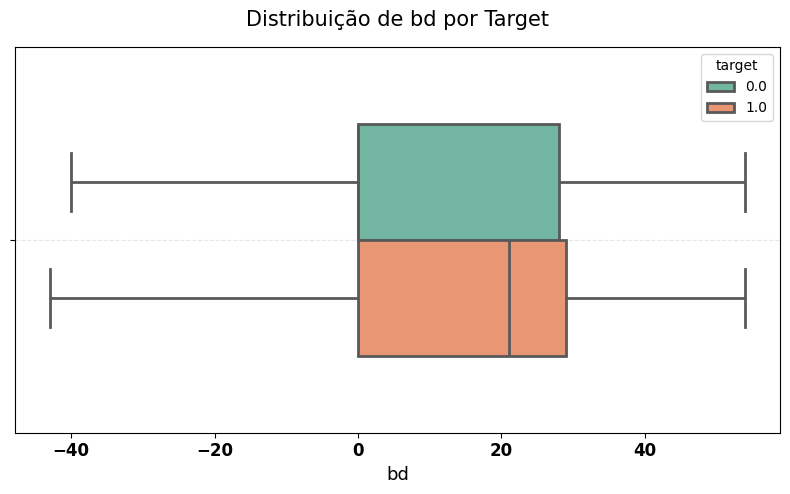

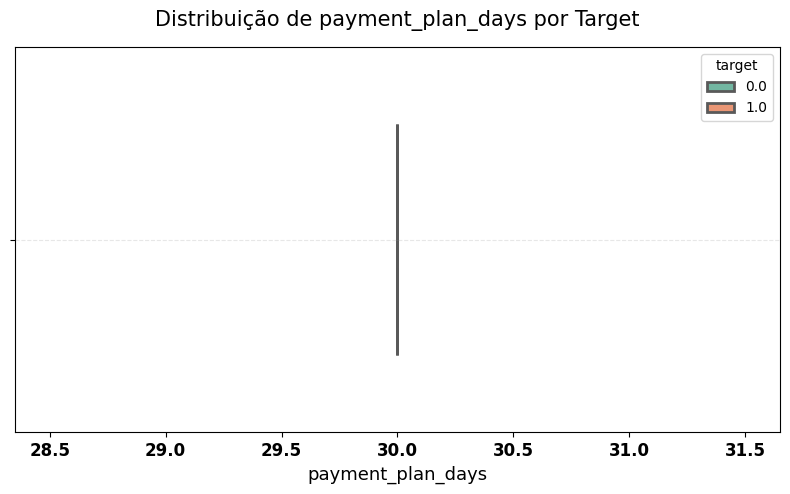

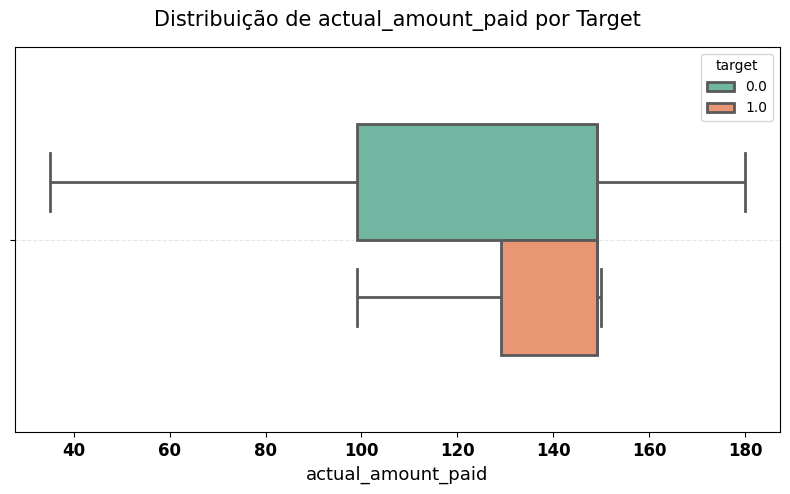

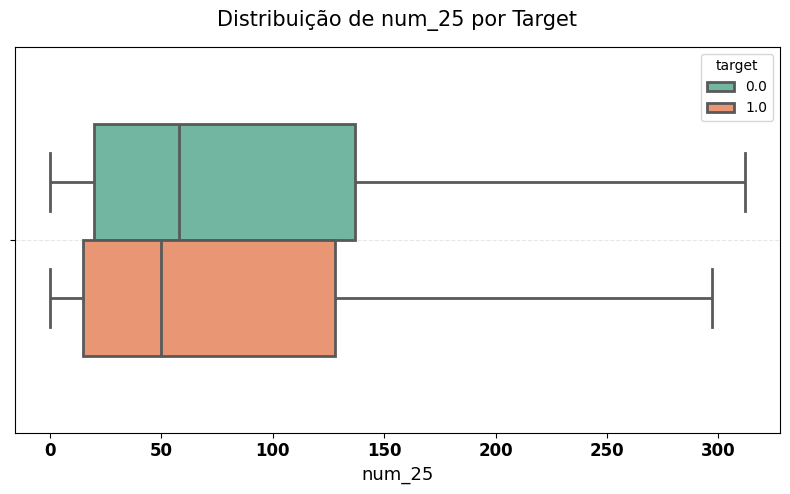

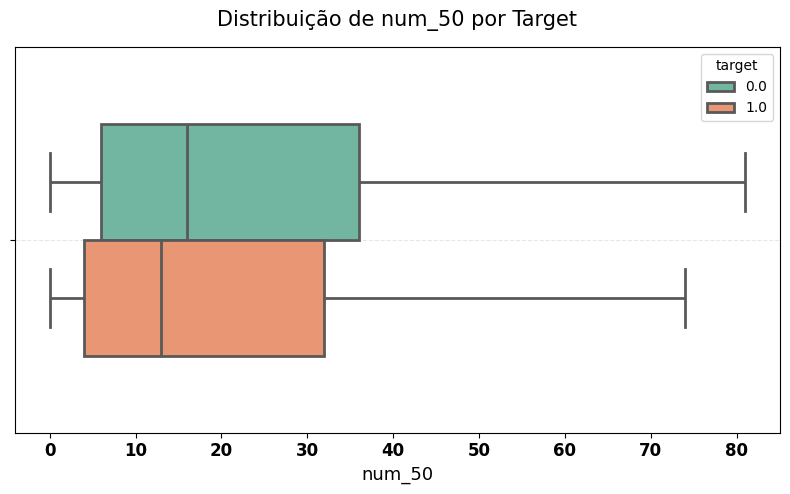

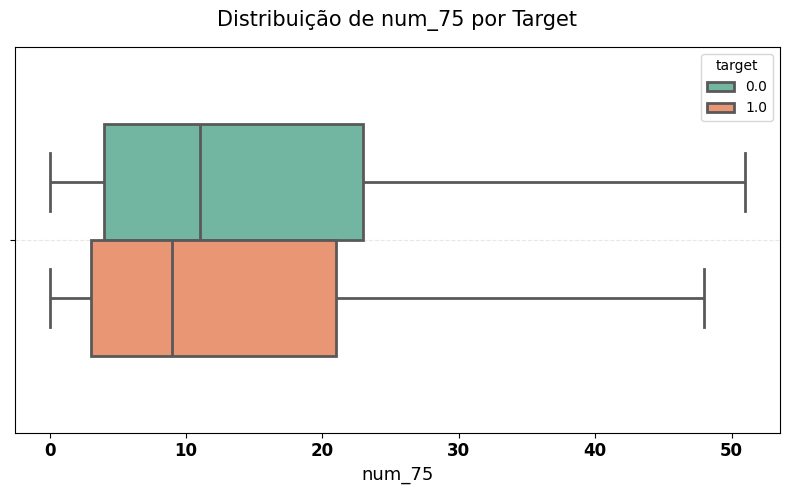

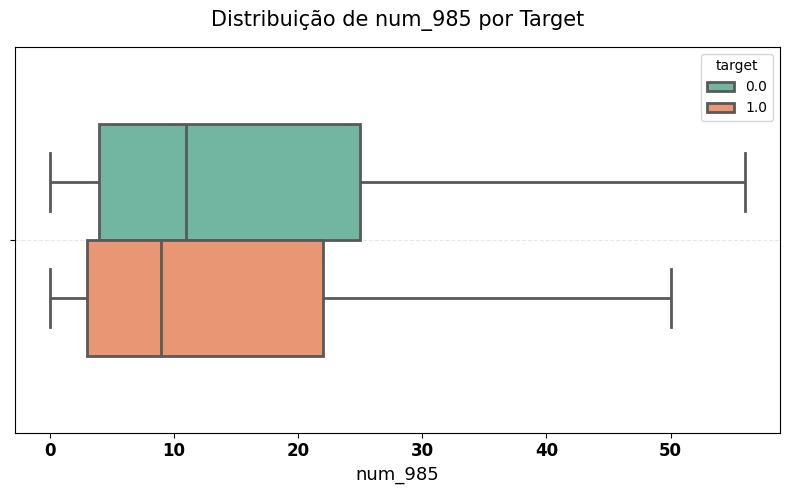

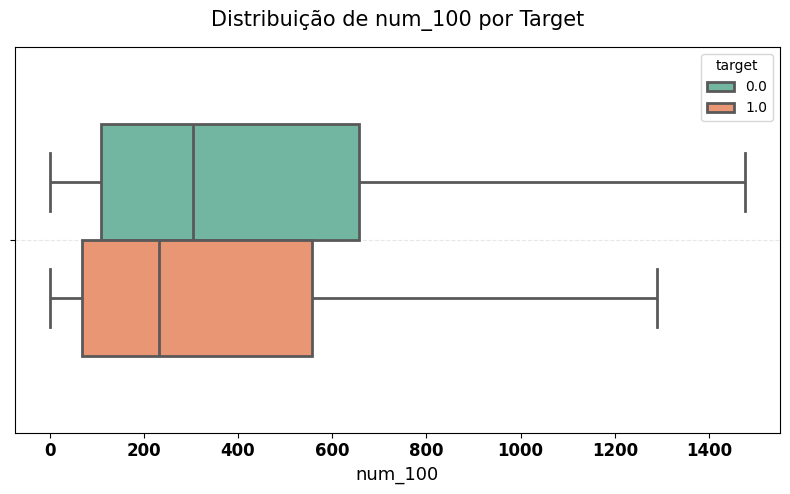

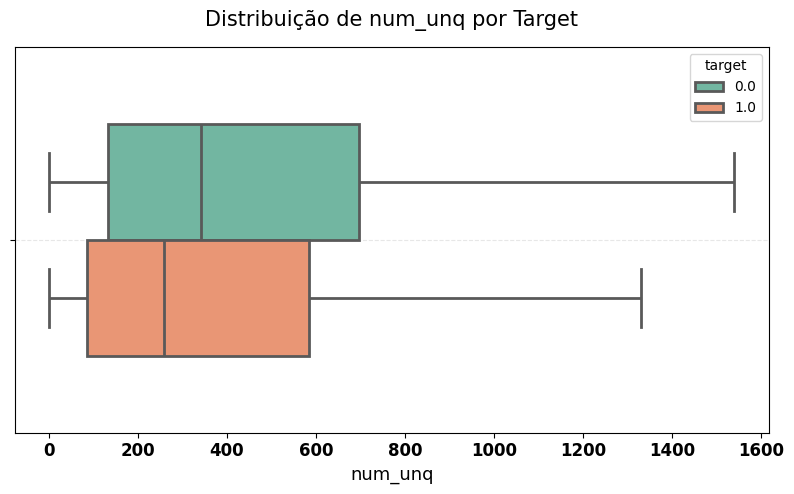

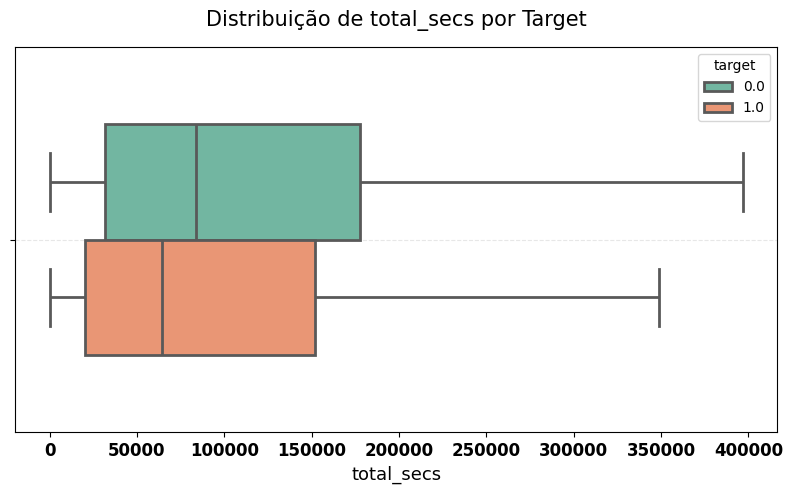

In [ ]:
for i in num_cols:
  plt.figure(figsize=(8, 5))  # Ajusta o tamanho
  p99 = train[i].quantile(0.99)
  p1 = train[i].quantile(0.01)
  df_plot = train[(train[i] <= p99)]# & (train['bd'] >= p1)]
  sns.boxplot(data=df_plot,hue='target',x=i,orient='h',palette='Set2',showfliers=False, linewidth=2,width=0.6)
  plt.title(f'Distribuição de {i} por Target', fontsize=15, pad=15)
  plt.xlabel(i, fontsize=13)
  plt.grid(axis='y', linestyle='--', alpha=0.3)
  plt.tight_layout()
  plt.xticks(fontsize=12, weight='bold')
  plt.show()

## Criação de novas features
- tempo_expiracao : utilizar os tempo da safra atual até a data de expiracao do plano. Para os valores nulos, utiliza-se o valor médio do tempo de expiracao.
- tempo_iniciacao : tempo desde que se tornou membro pela primeira vez
- Estatistica dos minutos escutados nos utimos meses, mostrando uma tendencia dos dados históricos do perfil de musicas escutadas pelo cliente.

In [ ]:
train['tempo_expiracao'] = (pd.to_datetime(train['membership_expire_date']) - pd.to_datetime(train['safra'])).dt.days
train['tempo_iniciacao'] = (pd.to_datetime(train['safra']) - pd.to_datetime(train['registration_init_time'])).dt.days
test['tempo_expiracao'] = (pd.to_datetime(test['membership_expire_date']) - pd.to_datetime(test['safra'])).dt.days
test['tempo_iniciacao'] = (pd.to_datetime(test['safra']) - pd.to_datetime(test['registration_init_time'])).dt.days
valid['tempo_expiracao'] = (pd.to_datetime(valid['membership_expire_date']) - pd.to_datetime(valid['safra'])).dt.days
valid['tempo_iniciacao'] = (pd.to_datetime(valid['safra']) - pd.to_datetime(valid['registration_init_time'])).dt.days
oot['tempo_expiracao'] = (pd.to_datetime(oot['membership_expire_date']) - pd.to_datetime(oot['safra'])).dt.days
oot['tempo_iniciacao'] = (pd.to_datetime(oot['safra']) - pd.to_datetime(oot['registration_init_time'])).dt.days

In [ ]:
train[['tempo_expiracao', 'tempo_iniciacao']].describe(percentiles=[0.01,0.025, 0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9, 0.95, 0.98 ,0.99])

,tempo_expiracao,tempo_iniciacao
count,84882.000000,102161.000000
mean,49.674536,1146.124568
std,22.614545,1063.515195
min,-1.000000,-30.000000
1%,17.000000,-15.000000
2.5%,30.000000,4.000000
10%,33.000000,102.000000
20%,36.000000,204.000000
30%,40.000000,324.000000
40%,44.000000,604.000000


# Pré-processamento

### **Tratamento dos nulos**

**Transações**

Para as colunas provenientes da base de transações, assume-se que os valores nulos são provenientes de cliente com plano com renovação maior que um mês. Nesse caso o cliente não realizou transferencia no mes, mas continua ativo (membership_expire_date > safra).

Utiliza-se entao, os valores medios das transacoes com payment_plan_days maior que 30 dias para as colunas payment_plan_days, actual_amount_paid, is_auto_renew

In [ ]:
transacoes = df_transactions.filter((F.col('payment_plan_days')> 30)&(F.col('safra')<='2016-08-01'))

In [ ]:
ids = train[train['payment_plan_days'].isnull()]['msno'].unique().tolist()

In [ ]:
transacoes = transacoes.filter(F.col('msno').isin(ids))

In [ ]:
payment_plan_days = transacoes.agg(F.mean('payment_plan_days')).collect()[0][0]
plan_list_price = transacoes.agg(F.mean('plan_list_price')).collect()[0][0]
actual_amount_paid = transacoes.agg(F.mean('actual_amount_paid')).collect()[0][0]
train['payment_plan_days'] = train['payment_plan_days'].fillna(payment_plan_days)
train['plan_list_price'] = train['plan_list_price'].fillna(plan_list_price)
train['actual_amount_paid'] = train['actual_amount_paid'].fillna(actual_amount_paid)
test['payment_plan_days'] = test['payment_plan_days'].fillna(payment_plan_days)
test['plan_list_price'] = test['plan_list_price'].fillna(plan_list_price)
test['actual_amount_paid'] = test['actual_amount_paid'].fillna(actual_amount_paid)
valid['payment_plan_days'] = valid['payment_plan_days'].fillna(payment_plan_days)
valid['plan_list_price'] = valid['plan_list_price'].fillna(plan_list_price)
valid['actual_amount_paid'] = valid['actual_amount_paid'].fillna(actual_amount_paid)
oot['payment_plan_days'] = oot['payment_plan_days'].fillna(payment_plan_days)
oot['plan_list_price'] = oot['plan_list_price'].fillna(plan_list_price)
oot['actual_amount_paid'] = oot['actual_amount_paid'].fillna(actual_amount_paid)

**Váriáveis categóricas**

Para as variaveis categóricas, opta-se por criar uma nova categoria 'sem_registro'

In [ ]:
for col in cat_cols:
    train[col] = train[col].fillna('sem_registro')
    test[col] = test[col].fillna('sem_registro')
    valid[col] = valid[col].fillna('sem_registro')
    oot[col] = oot[col].fillna('sem_registro')

**Variáveis numéricas**

In [ ]:
num_cols.append('tempo_expiracao')
num_cols.append('tempo_iniciacao')
for col in num_cols:
    train[col] = train[col].astype('float64')
    test[col] = test[col].astype('float64')
    valid[col] = valid[col].astype('float64')
    oot[col] = oot[col].astype('float64')
    mean = train[col].mean()
    train[col] = train[col].fillna(mean)
    test[col] = test[col].fillna(mean)
    valid[col] = valid[col].fillna(mean)
    oot[col] = oot[col].fillna(mean)

### **Tratamento de outliers**

Observa-se que algumas variaveis numericas possuem outliers, e então decide-se utilizar como maximo o percentile 0.99 e como minimo o percentile 0.01.

A variavel bd, que representa a idade do cliente membro, apresenta alguns valores maiores que 100 anos possui e muitos valores iguais ou menores que zero, algo que não faz sentido. Desta forma, separa-se apenas os valores maior que zero e até 100, e entao utiliza-se o percentile 0.01 e 0.99 dessa amostra, para servirem como minimos e maximos para essa variavel.

Para o tempo de iniciação, foram observados alguns valores negativos, desta forma, usa-se como piso o valor do percentile 0.025.

In [ ]:
aux = train[(train['bd']>0)&(train['bd']<100)]
p1 = aux['bd'].quantile(0.01)
p99 = aux['bd'].quantile(0.99)
train['bd'] = np.where(train['bd'] < p1, p1, train['bd'])
train['bd'] = np.where(train['bd'] > p99, p99, train['bd'])
test['bd'] = np.where(test['bd'] < p1, p1, test['bd'])
test['bd'] = np.where(test['bd'] > p99, p99, test['bd'])
valid['bd'] = np.where(valid['bd'] < p1, p1, valid['bd'])
valid['bd'] = np.where(valid['bd'] > p99, p99, valid['bd'])
oot['bd'] = np.where(oot['bd'] < p1, p1, oot['bd'])
oot['bd'] = np.where(oot['bd'] > p99, p99, oot['bd'])

In [ ]:
for i in num_cols:
    if i == 'bd':
        pass
    if i == 'tempo_iniciacao':
        p99 = train[i].quantile(0.99)
        p025 = train[i].quantile(0.025)
        train[i] = train[i].clip(lower=p025, upper=p99, axis=0)
        test[i] = test[i].clip(lower=p025, upper=p99, axis=0)
        valid[i] = valid[i].clip(lower=p025, upper=p99, axis=0)
        oot[i] = oot[i].clip(lower=p025, upper=p99, axis=0)
    p99 = train[i].quantile(0.99)
    p1 = train[i].quantile(0.01)
    train[i] = train[i].clip(lower=p1, upper=p99, axis=0)
    test[i] = test[i].clip(lower=p1, upper=p99, axis=0)
    valid[i] = valid[i].clip(lower=p1, upper=p99, axis=0)
    oot[i] = oot[i].clip(lower=p1, upper=p99, axis=0)

In [ ]:
# Retirando colunas que não serão utilizadas
drop_cols = ['chave', 'registration_init_time','membership_expire_date', 'is_ativo', 'safra_target']
train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)
valid = valid.drop(columns=drop_cols)
oot = oot.drop(columns=drop_cols)

## **Encoding das variaveis categóricas**

Para o pré-processamento das variaveis categóricas, utiliza-se um target encoding.


In [ ]:
cat_cols = ['city', 'gender', 'registered_via','is_auto_renew', 'is_cancel']
num_cols = ['bd', 'payment_plan_days', 'plan_list_price', 'actual_amount_paid',
            'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs',
            'tempo_expiracao', 'tempo_iniciacao']
for i in cat_cols:
    train[i] = train[i].astype('str')
    test[i] = test[i].astype('str')
    valid[i] = valid[i].astype('str')
    oot[i] = oot[i].astype('str')
for i in num_cols:
    train[i] = train[i].astype('float64')
    test[i] = test[i].astype('float64')
    valid[i] = valid[i].astype('float64')
    oot[i] = oot[i].astype('float64')


In [ ]:
# target encoding para as variaveis categóricas

def target_encode(train, test, valid, oot, cat_cols, target_col):
    for col in cat_cols:
        # Calcula a média do target para cada categoria
        mean_target = train.groupby(col)[target_col].mean().to_dict()

        # Mapeia a média do target para cada categoria no conjunto de treino
        train[col+'_te'] = train[col].map(mean_target).fillna(train[target_col].mean())
        test[col+'_te'] = test[col].map(mean_target).fillna(train[target_col].mean())
        valid[col+'_te'] = valid[col].map(mean_target).fillna(train[target_col].mean())
        oot[col+'_te'] = oot[col].map(mean_target).fillna(train[target_col].mean())

        # Converte a coluna de target encoding para float64
        train[col+'_te'] = train[col+'_te'].astype('float64')
        test[col+'_te'] = test[col+'_te'].astype('float64')
        valid[col+'_te'] = valid[col+'_te'].astype('float64')
        oot[col+'_te'] = oot[col+'_te'].astype('float64')
    return train, test, valid, oot
train, test, valid, oot = target_encode(train, test, valid, oot, cat_cols, 'target')

In [ ]:
# Salvando os DataFrames em arquivos CSV
train.to_csv("/content/drive/MyDrive/Data Master/train.csv", index=False)
test.to_csv("/content/drive/MyDrive/Data Master/test.csv", index=False)
valid.to_csv("/content/drive/MyDrive/Data Master/valid.csv", index=False)
oot.to_csv("/content/drive/MyDrive/Data Master/oot.csv", index=False)

# **Feature Selection**

Para a seleção das features, foi realizada uma analise de feature importance utilizando Random Forest, determinando a quantidade otima de features com RFECV, que realiza uma validação cruzada com folds estratificadas, a fim de manter a proporção das classes da target, e itertivamente retira features uma a uma, comparando a performance dos modelos com cada conjunto de features.

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Data Master/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Data Master/test.csv")
valid = pd.read_csv("/content/drive/MyDrive/Data Master/valid.csv")
oot = pd.read_csv("/content/drive/MyDrive/Data Master/oot.csv")
base = pd.concat([train, test, valid, oot])

In [ ]:
cols = ['payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'num_25', 'num_50', 'num_75',
       'num_985', 'num_100', 'num_unq', 'total_secs', 'tempo_expiracao',
       'tempo_iniciacao', 'city_te', 'gender_te', 'registered_via_te',
       'is_auto_renew_te', 'is_cancel_te']

In [ ]:
X_train = train[cols]
y_train = train['target']
X_test = test[cols]
y_test = test['target']
X_valid = valid[cols]
y_valid = valid['target']
X_oot = oot[cols]
y_oot = oot['target']

In [ ]:
# Parâmetros do modelo
rf_params = dict(
    n_estimators=50,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# Features (já numéricas, incluindo as target-encoded)
feature_names = X_train.columns.tolist()

# Stratified KFold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
importances = []

for train_idx, val_idx in skf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Ajusta o modelo diretamente nos dados já numéricos
    rf = RandomForestClassifier(**rf_params)
    rf.fit(X_tr, y_tr)
    importances.append(rf.feature_importances_)

# Importância média
importances = np.array(importances)
mean_importances = importances.mean(axis=0)

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_importances
}).sort_values(by='importance', ascending=False)

print(feat_imp)

# # Seleção das TOP N
# N = 15
# top_features = feat_imp.head(N)['feature'].tolist()
# print("\nTop features (cross-validated):", top_features)
# Defina o seu threshold (por exemplo, 0.01)

threshold = 0.01

# Selecionar features acima do threshold
top_features = feat_imp[feat_imp['importance'] > threshold]['feature'].tolist()
print(f"Features selecionadas (importância > {threshold}):", top_features)
# Aplicando seleção de features nas outras bases:
X_train_sel = X_train[top_features]
X_val_sel = X_val[top_features]
X_test_sel = X_test[top_features]
X_oot_sel = X_oot[top_features]


               feature  importance
15    is_auto_renew_te    0.336261
16        is_cancel_te    0.203456
2   actual_amount_paid    0.116937
14   registered_via_te    0.093284
10     tempo_expiracao    0.092008
1      plan_list_price    0.072774
0    payment_plan_days    0.028645
12             city_te    0.009211
11     tempo_iniciacao    0.008334
8              num_unq    0.008144
13           gender_te    0.007538
9           total_secs    0.006641
7              num_100    0.005525
5               num_75    0.003487
6              num_985    0.002676
3               num_25    0.002617
4               num_50    0.002462
Features selecionadas (importância > 0.01): ['is_auto_renew_te', 'is_cancel_te', 'actual_amount_paid', 'registered_via_te', 'tempo_expiracao', 'plan_list_price', 'payment_plan_days']


In [ ]:
# Salvando as bases processadas e selecionadas
X_train_sel.to_csv("/content/drive/MyDrive/Data Master/X_train_sel.csv", index=False)
X_val_sel.to_csv("/content/drive/MyDrive/Data Master/X_val_sel.csv", index=False)
X_test_sel.to_csv("/content/drive/MyDrive/Data Master/X_test_sel.csv", index=False)
X_oot_sel.to_csv("/content/drive/MyDrive/Data Master/X_oot_sel.csv", index=False)
# Salvando os alvos
y_train.to_csv("/content/drive/MyDrive/Data Master/y_train.csv", index=False)
y_val.to_csv("/content/drive/MyDrive/Data Master/y_val.csv", index=False)
y_test.to_csv("/content/drive/MyDrive/Data Master/y_test.csv", index=False)
y_oot.to_csv("/content/drive/MyDrive/Data Master/y_oot.csv", index=False)
# Salvando lista de variaveis selecionadas
with open("/content/drive/MyDrive/Data Master/top_features.txt", "w") as f:
    for feature in top_features:
        f.write(f"{feature}\n")

# **Modelo**
O objetivo do modelo é prever se um cliente é churn ou não, após 3 meses. Para os clientes classificados como churn, é aplicada uma ação de retenção, oferecendo 3 meses de graça. Estima-se que com a ação, 50% dos clientes ficam retidos por 1 ano.

Dessa forma o impacto das previsões do modelo seriam:

**Verdadeiro Positivo (TP):** Cliente classificado como churn, e realmente seria churn. É aplicada a ação, e arca-se com o custo de 3 meses de mensalidade do cliente que não seria churn.

**Verdadeiro Negativo (TN):** Cliente classificado como não churn, e realmente não é. Não há custo, nem retorno.

**Falso Positivo:** Cliente é classificado como churn, no entanto ele não seria churn. É aplicada a ação, e arca-se com o custo da ação, mas tem um retorno de 9 meses de assinatura.

**Falso Negativo:** Cliente é classificado como não churn, no entanto ele se torna churn. Nenhuma ação ocorre e implica na possivel perda de um cliente. Não há custo, nem retorno.

Dessa forma, o melhor cenário seria:

- Maximizar os Verdadeiros Positivos, mantendo clientes churn.

- Minimizar os Falso Positivo, para controle dos custos com a ação.

Visto isso, opta-se otimizar a metrica de auc, que mede o quanto o modelo separar as classes

In [ ]:
X_train = pd.read_csv("/content/drive/MyDrive/Data Master/X_train_sel.csv")
X_val = pd.read_csv("/content/drive/MyDrive/Data Master/X_val_sel.csv")
X_test = pd.read_csv("/content/drive/MyDrive/Data Master/X_test_sel.csv")
X_oot = pd.read_csv("/content/drive/MyDrive/Data Master/X_oot_sel.csv")
y_train = pd.read_csv("/content/drive/MyDrive/Data Master/y_train.csv")
y_val = pd.read_csv("/content/drive/MyDrive/Data Master/y_val.csv")
y_test = pd.read_csv("/content/drive/MyDrive/Data Master/y_test.csv")
y_oot = pd.read_csv("/content/drive/MyDrive/Data Master/y_oot.csv")

In [ ]:
X_test.head()

,is_auto_renew_te,is_cancel_te,actual_amount_paid,registered_via_te,tempo_expiracao,plan_list_price,payment_plan_days
0,0.043341,0.071697,99.0,0.041510,32.0,99.0,30.0
1,0.043341,0.071697,149.0,0.156402,46.0,149.0,30.0
2,0.043341,0.071697,99.0,0.041510,34.0,99.0,30.0
3,0.319122,0.071697,149.0,0.204054,56.0,149.0,30.0
4,0.319122,0.071697,150.0,0.204054,54.0,150.0,30.0


## Escolha do algorimo

Para escolher o algoritmo que será utilizado na criação do modelo de classificação, testa-se 3 algoritmos diferentes, regressão logística, RandomForest e XGBoost, de forma rápida, a fim de comparar as performances e selecionar o algoritmo.

Desta forma, cria-se um pipeline de pre-processamento e modelagem simples para cada algoritmo, e então coleta-se metricas de performance do modelo para a decisão.

In [ ]:
# Supondo que X_train, X_test já têm todas as variáveis numéricas (inclusive target-encoded)
num_cols = X_train.columns.tolist()  # já são todas numéricas

class_weight = {0: 1, 1: 10}

# Preprocessing pipelines (só padronização, se quiser)
preprocessors = {
    "logreg": StandardScaler(),   # útil para regressão logística
    "rf": 'passthrough',          # Random Forest não precisa
    "xgb": 'passthrough',         # XGBoost também não precisa
}

# Modelos ajustados com balanceamento e hiperparâmetros relevantes
models = {
    "logreg": LogisticRegression(
        max_iter=500,
        class_weight=class_weight,
        C=0.5
    ),
    "rf": RandomForestClassifier(
        n_estimators=200,
        max_depth=6,
        min_samples_leaf=5,
        min_samples_split=10,
        n_jobs=-1,
        random_state=42,
        class_weight=class_weight
    ),
    "xgb": xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=class_weight[1],
        n_jobs=-1,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
}

# Pipeline + avaliação rápida
for name in models:
    pipe = Pipeline([
        ('pre', preprocessors[name]),
        ('clf', models[name])
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    print(f"\n=== {name.upper()} ===")
    print("AUC:", roc_auc_score(y_test, y_proba))
    print(classification_report(y_test, y_pred, digits=3))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



=== LOGREG ===
AUC: 0.8424252450491251
              precision    recall  f1-score   support

         0.0      0.973     0.768     0.859     25054
         1.0      0.320     0.836     0.463      3264

    accuracy                          0.776     28318
   macro avg      0.646     0.802     0.661     28318
weighted avg      0.898     0.776     0.813     28318



/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



=== RF ===
AUC: 0.8529545727796587
              precision    recall  f1-score   support

         0.0      0.973     0.769     0.859     25054
         1.0      0.321     0.837     0.464      3264

    accuracy                          0.777     28318
   macro avg      0.647     0.803     0.662     28318
weighted avg      0.898     0.777     0.814     28318



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:11:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGB ===
AUC: 0.8556445528638533
              precision    recall  f1-score   support

         0.0      0.975     0.765     0.857     25054
         1.0      0.320     0.850     0.465      3264

    accuracy                          0.774     28318
   macro avg      0.648     0.807     0.661     28318
weighted avg      0.900     0.774     0.812     28318



**Modelo Classificação Binaria**

Como visto nos testes iniciais, o algoritmo que apresentou uma melhor performance foi o XGBoost. Desta forma, segue-se para a modelagem utilizando esse algoritmo.

In [ ]:
def get_binary_classification_metrics(base, y_true, y_pred, y_pred_proba=None):
    """
    Retorna um DataFrame pandas com as principais métricas de avaliação para classificação binária.

    Parâmetros:
    - y_true: array-like, rótulos verdadeiros
    - y_pred: array-like, predições do modelo (0 ou 1)
    - y_pred_proba: array-like, probabilidades da classe positiva (opcional, recomendado)

    Retorno:
    - metrics_df: pandas.DataFrame com as métricas
    """

    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0)
    }
    metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
    metrics['pr_auc'] = average_precision_score(y_true, y_pred_proba)
    metrics['log_loss'] = log_loss(y_true, y_pred_proba)

    # Matriz de confusão (TP, FP, TN, FN)
    cm = confusion_matrix(y_true, y_pred)
    metrics['tn'] = cm[0, 0]
    metrics['fp'] = cm[0, 1]
    metrics['fn'] = cm[1, 0]
    metrics['tp'] = cm[1, 1]

    metrics['base'] = base

    return metrics


In [ ]:
# Defina o scale_pos_weight base:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Espaço de busca de hiperparâmetros
space = {
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators': hp.choice('n_estimators', range(50, 300)),
    'gamma': hp.uniform('gamma', 0, 5),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', scale_pos_weight * 0.5, scale_pos_weight * 2)
}

def objective(params):
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        **params
    )
    model.fit(X_train, y_train)
    probas = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, probas)
    return {'loss': -auc, 'status': STATUS_OK}

trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials,
    rstate=np.random.default_rng(42)
)

print("Melhores hiperparâmetros encontrados:", best)

# Recuperando os hiperparâmetros reais
best_params = {
    'max_depth': range(3, 10)[best['max_depth']],
    'learning_rate': best['learning_rate'],
    'n_estimators': range(50, 300)[best['n_estimators']],
    'gamma': best['gamma'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda'],
    'scale_pos_weight': best['scale_pos_weight']
}

# Treinando modelo final usando train + val
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    **best_params
)
final_model.fit(X_trainval, y_trainval)

# Avaliação em TESTE
y_proba_test = final_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= 0.5).astype(int)
print("\n--- Avaliação final no conjunto de TESTE ---")
print("AUC:", roc_auc_score(y_test, y_proba_test))
print(classification_report(y_test, y_pred_test, digits=3))

# Avaliação em OOT
y_proba_oot = final_model.predict_proba(X_oot)[:, 1]
y_pred_oot = (y_proba_oot >= 0.5).astype(int)
print("\n--- Avaliação final no conjunto OOT ---")
print("AUC:", roc_auc_score(y_oot, y_proba_oot))
print(classification_report(y_oot, y_pred_oot, digits=3))

100%|██████████| 30/30 [01:49<00:00,  3.64s/trial, best loss: -0.8756094303672748]
Melhores hiperparâmetros encontrados: {'colsample_bytree': np.float64(0.991651525388409), 'gamma': np.float64(0.6681224189532667), 'learning_rate': np.float64(0.16500844038480122), 'max_depth': np.int64(6), 'n_estimators': np.int64(213), 'reg_alpha': np.float64(0.8006268603539102), 'reg_lambda': np.float64(0.8053153219189922), 'scale_pos_weight': np.float64(7.873236520958541), 'subsample': np.float64(0.7105029732495001)}

--- Avaliação final no conjunto de TESTE ---
AUC: 0.848018812453336
              precision    recall  f1-score   support

         0.0      0.974     0.767     0.858     25054
         1.0      0.320     0.840     0.463      3264

    accuracy                          0.776     28318
   macro avg      0.647     0.804     0.661     28318
weighted avg      0.898     0.776     0.813     28318


--- Avaliação final no conjunto OOT ---
AUC: 0.8693721461171843
              precision    reca

In [ ]:
# Salvar o modelo treinado em formato .pkl
with open("/content/drive/MyDrive/Data Master/models/xgb_final_model.pkl", "wb") as f:
    pickle.dump(final_model, f)
print("Modelo salvo em /content/drive/MyDrive/Data Master/models/xgb_final_model.pkl")

Modelo salvo em /content/drive/MyDrive/Data Master/models/xgb_final_model.pkl


In [ ]:
# Avaliação do modelo
y_pred_train = final_model.predict(X_train)
y_proba_train = final_model.predict_proba(X_train)[:, 1]
y_pred_test = final_model.predict(X_test)
y_proba_test = final_model.predict_proba(X_test)[:, 1]
y_pred_oot = final_model.predict(X_oot)
y_proba_oot = final_model.predict_proba(X_oot)[:, 1]


In [ ]:
metrics_train = get_binary_classification_metrics('treino',y_train, y_pred_train, y_proba_train)
metrics_test = get_binary_classification_metrics('teste', y_test, y_pred_test, y_proba_test)
metrics_oot = get_binary_classification_metrics('oot', y_oot, y_pred_oot, y_proba_oot)
metrics_df = pd.DataFrame([metrics_train, metrics_test, metrics_oot])
metrics_df

,accuracy,precision,recall,f1_score,roc_auc,pr_auc,log_loss,tn,fp,fn,tp,base
0,0.783479,0.333063,0.869289,0.481603,0.873215,0.515917,0.440189,69766,20575,1545,10275,treino
1,0.775690,0.319837,0.839767,0.463242,0.848019,0.471917,0.461117,19225,5829,523,2741,teste
2,0.809553,0.391319,0.853875,0.536683,0.869372,0.595098,0.418842,22004,5399,594,3471,oot


## **Seleção de Threshoud**

Após a criação do modelos, avalia-se o threshould que traga maiores retornos financeiros.

**Retorno Financeiro**

TP: após 3 meses, contabiliza (actual_amount_paid*9) como receita.

FP: durante 3 meses, contabiliza o (actual_amount_paid*3) como despesa.

Impacto aproximado: total de receitas da base

In [51]:
train = pd.read_csv("/content/drive/MyDrive/Data Master/train.csv")
valid = pd.read_csv("/content/drive/MyDrive/Data Master/valid.csv")
selected_features = pd.read_csv("/content/drive/MyDrive/Data Master/top_features.txt", header=None)
selected_features = selected_features[0].tolist()
X_train = train[selected_features]
X_valid = valid[selected_features]

In [50]:
# carregar o modelo
with open('/content/drive/MyDrive/Data Master/models/xgb_final_model.pkl', 'rb') as f:
    final_model = pickle.load(f)

print("Modelo carregado com sucesso!")

Modelo carregado com sucesso!


In [52]:
train['proba'] = final_model.predict_proba(X_train)[:, 1]
train['pred'] = final_model.predict(X_train)
valid['proba'] = final_model.predict_proba(X_valid)[:, 1]
valid['pred'] = final_model.predict(X_valid)

In [54]:
def calculate_financial_return(df, threshold):
    df_threshold = df.copy()
    df_threshold['prediction_threshold'] = (df_threshold['proba'] >= threshold).astype(int)

    # Calcular TP, FP, TN, FN
    tp = ((df_threshold['target'] == 1) & (df_threshold['prediction_threshold'] == 1)).sum()
    fp = ((df_threshold['target'] == 0) & (df_threshold['prediction_threshold'] == 1)).sum()
    tn = ((df_threshold['target'] == 0) & (df_threshold['prediction_threshold'] == 0)).sum()
    fn = ((df_threshold['target'] == 1) & (df_threshold['prediction_threshold'] == 0)).sum()

    # Calcular retorno financeiro
    # Assumimos o actual_amount_paid médio dos TPs e FPs para o cálculo
    avg_amount_paid_tp = df_threshold.loc[((df_threshold['target'] == 1) & (df_threshold['prediction_threshold'] == 1)), 'actual_amount_paid'].mean()
    avg_amount_paid_fp = df_threshold.loc[((df_threshold['target'] == 0) & (df_threshold['prediction_threshold'] == 1)), 'actual_amount_paid'].mean()

    # Se não houver TP ou FP para o threshold, o retorno é 0 ou NaN.
    # Tratamos como 0 nesse caso.
    revenue_tp = (tp * avg_amount_paid_tp * 9) if not pd.isna(avg_amount_paid_tp) else 0
    cost_fp = (fp * avg_amount_paid_fp * 3) if not pd.isna(avg_amount_paid_fp) else 0

    financial_return = revenue_tp - cost_fp

    return financial_return, tp, fp

Melhor Threshold para maximizar o retorno financeiro: 0.7143
Retorno Financeiro Máximo Estimado: 6,809,086.63


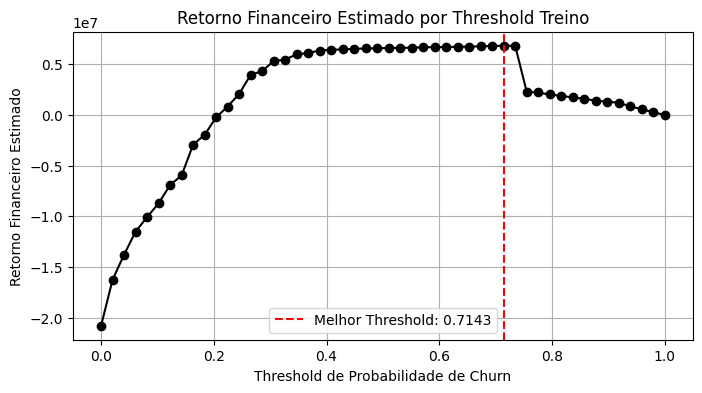

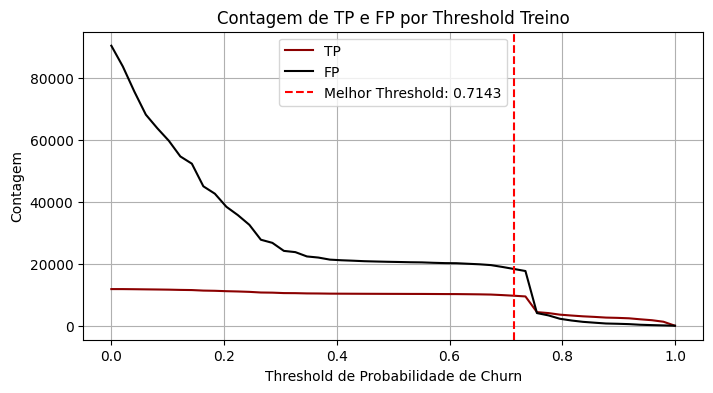

In [56]:
# Base de treino

# Iterar sobre diferentes thresholds
thresholds = np.linspace(0, 1, 50) # Testa thresholds de 0 a 1 com passos de 0.01
returns = []
tp_counts = []
fp_counts = []

for thresh in thresholds:
    financial_return, tp, fp = calculate_financial_return(train, thresh)
    returns.append(financial_return)
    tp_counts.append(tp)
    fp_counts.append(fp)

# Encontrar o threshold que maximiza o retorno financeiro
best_threshold_index = np.argmax(returns)
best_threshold = thresholds[best_threshold_index]
max_return = returns[best_threshold_index]

print(f"Melhor Threshold para maximizar o retorno financeiro: {best_threshold:.4f}")
print(f"Retorno Financeiro Máximo Estimado: {max_return:,.2f}")

plt.figure(figsize=(8, 4))
plt.plot(thresholds, returns, marker='o', linestyle='-', color="#000000")
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Melhor Threshold: {best_threshold:.4f}')
plt.title('Retorno Financeiro Estimado por Threshold Treino')
plt.xlabel('Threshold de Probabilidade de Churn')
plt.ylabel('Retorno Financeiro Estimado')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(thresholds, tp_counts, label='TP', color="#8B0000")
plt.plot(thresholds, fp_counts, label='FP', color="#000000")
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Melhor Threshold: {best_threshold:.4f}')
plt.title('Contagem de TP e FP por Threshold Treino')
plt.xlabel('Threshold de Probabilidade de Churn')
plt.ylabel('Contagem')
plt.grid(True)
plt.legend()
plt.show()

Melhor Threshold para maximizar o retorno financeiro: 0.7347
Retorno Financeiro Máximo Estimado: 669,687.93


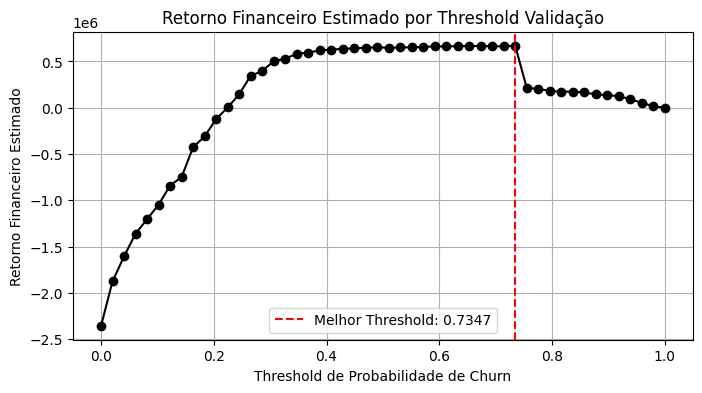

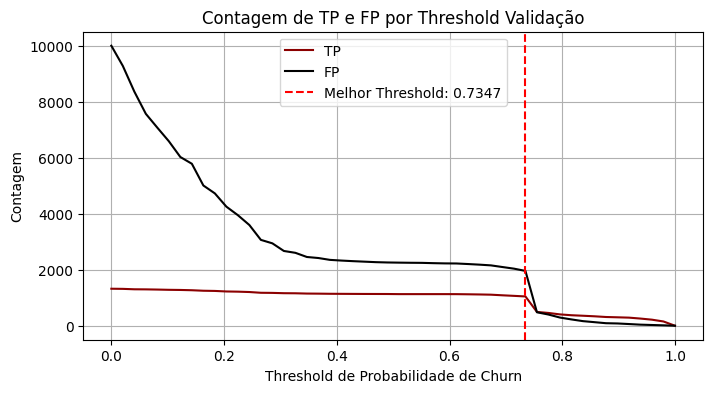

In [58]:
# Base de validação

# Iterar sobre diferentes thresholds
thresholds = np.linspace(0, 1, 50) # Testa thresholds de 0 a 1 com passos de 0.01
returns = []
tp_counts = []
fp_counts = []

for thresh in thresholds:
    financial_return, tp, fp = calculate_financial_return(valid, thresh)
    returns.append(financial_return)
    tp_counts.append(tp)
    fp_counts.append(fp)

# Encontrar o threshold que maximiza o retorno financeiro
best_threshold_index = np.argmax(returns)
best_threshold = thresholds[best_threshold_index]
max_return = returns[best_threshold_index]

print(f"Melhor Threshold para maximizar o retorno financeiro: {best_threshold:.4f}")
print(f"Retorno Financeiro Máximo Estimado: {max_return:,.2f}")

plt.figure(figsize=(8, 4))
plt.plot(thresholds, returns, marker='o', linestyle='-', color="#000000")
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Melhor Threshold: {best_threshold:.4f}')
plt.title('Retorno Financeiro Estimado por Threshold Validação')
plt.xlabel('Threshold de Probabilidade de Churn')
plt.ylabel('Retorno Financeiro Estimado')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(thresholds, tp_counts, label='TP', color="#8B0000")
plt.plot(thresholds, fp_counts, label='FP', color="#000000")
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Melhor Threshold: {best_threshold:.4f}')
plt.title('Contagem de TP e FP por Threshold Validação')
plt.xlabel('Threshold de Probabilidade de Churn')
plt.ylabel('Contagem')
plt.grid(True)
plt.legend()
plt.show()

## **Análise de impacto**

- Montagem de um fluxo de escoragem, utilizando um threshould de 0.7.
- Calculo do retorno financeiro
- Calculo da taxa de retenção dos clietes

In [12]:
def score_new_data(df):

    # Define the paths to the saved model and feature list
    model_file_path = "/content/drive/MyDrive/Data Master/models/xgb_final_model.pkl"
    features_file_path = "/content/drive/MyDrive/Data Master/top_features.txt"

    threshold=0.7

    # Carregar o modelo treinado
    with open(model_file_path, 'rb') as f:
        model = pickle.load(f)
    print("Modelo carregado com sucesso!")

    # Carregar a lista de features selecionadas
    with open(features_file_path, 'r') as f:
        selected_features = [line.strip() for line in f if line.strip()]
    print(f"Features selecionadas carregadas: {selected_features}")

    X = df[selected_features]

    # --- Escoragem ---
    print("Escorando os novos dados...")
    probabilities = model.predict_proba(X)[:, 1]
    predictions = (probabilities >= threshold).astype(int)

    # Adicionar probabilidades e predições ao DataFrame original (Pandas)
    df['proba'] = probabilities
    df['prediction'] = predictions

    base['verdadeiro_churn'] = (base['target'] == 1) & (base['prediction'] == 1)
    base['falso_churn'] = (base['target'] == 0) & (base['prediction'] == 1)

    conditions = [
    df['verdadeiro_churn'] == True,  # Condition 1: Verdadeiro Churn
    df['falso_churn'] == True        # Condition 2: Falso Churn
    ]

    values = [
        df['actual_amount_paid']*9,        # Value for Condition 1: actual_amount_paid
        -df['actual_amount_paid']*3        # Value for Condition 2: -actual_amount_paid
    ]
    base['impacto_financeiro'] = np.select(conditions, values, default=0)

    print("Escoragem concluída.")
    return df
train= pd.read_csv("/content/drive/MyDrive/Data Master/train.csv")
valid = pd.read_csv("/content/drive/MyDrive/Data Master/valid.csv")
test = pd.read_csv("/content/drive/MyDrive/Data Master/test.csv")
oot = pd.read_csv("/content/drive/MyDrive/Data Master/oot.csv")
train['base']='train'
valid['base']='valid'
test['base']='test'
oot['base']='oot'
base = pd.concat([train, valid, test, oot])
scored_data_df = score_new_data(base)

Modelo carregado com sucesso!
Features selecionadas carregadas: ['is_auto_renew_te', 'is_cancel_te', 'actual_amount_paid', 'registered_via_te', 'tempo_expiracao', 'plan_list_price', 'payment_plan_days']
Escorando os novos dados...
Escoragem concluída.


In [13]:
scored_data_df.head()

,msno,city,bd,gender,registered_via,safra,target,is_auto_renew,payment_plan_days,plan_list_price,actual_amount_paid,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,tempo_expiracao,tempo_iniciacao,city_te,gender_te,registered_via_te,is_auto_renew_te,is_cancel_te,base,proba,prediction,verdadeiro_churn,falso_churn,impacto_financeiro
0,zp1fkpGmGRdHidzu0rARjtQmrBCazmHEOLdck5wMp3o=,1.0,17.0,sem_registro,7.0,2016-05-01,0.0,1.0,30.0,99.0,99.0,0.0,114.528787,28.740476,18.008591,20.255956,536.278642,526.428807,141709.311191,34.0,271.0,0.080929,0.083455,0.041510,0.043341,0.071697,train,0.011120,0,False,False,0.0
1,YnQUHn4iid3ntFGo9drmZUgHOBtqE4W2wyMbQ5EPXyA=,13.0,29.0,female,7.0,2016-04-01,0.0,1.0,30.0,149.0,149.0,0.0,283.000000,62.000000,41.000000,45.000000,3577.200000,2865.000000,900460.786800,44.0,1387.0,0.137147,0.146753,0.041510,0.043341,0.071697,train,0.091135,0,False,False,0.0
2,NpidcMRW6UP/Y+CtsmwQ2EeHlOnH8uNrhjPo4hfhy0I=,13.0,25.0,female,7.0,2016-05-01,0.0,1.0,30.0,129.0,129.0,1.0,138.000000,44.000000,24.000000,19.000000,1229.000000,1322.000000,300332.541000,19.0,696.0,0.137147,0.146753,0.041510,0.043341,0.683012,train,0.835396,1,False,True,-387.0
3,/lWUM1gUbQNqgALnmbRRLiuQxuwdKO68f3Sx0tauoLU=,1.0,17.0,sem_registro,7.0,2016-08-01,0.0,1.0,30.0,149.0,149.0,0.0,58.000000,27.000000,20.000000,11.000000,1108.000000,483.000000,243377.255000,40.0,933.0,0.080929,0.083455,0.041510,0.043341,0.071697,train,0.244264,0,False,False,0.0
4,Z7wUDfcT+/Ru/kYR3b3ajGHQXBEubfKjWGpvaY3nvL0=,8.0,26.0,male,9.0,2016-06-01,0.0,1.0,30.0,149.0,149.0,0.0,33.000000,15.000000,10.000000,18.000000,919.000000,924.000000,240312.504000,52.0,1986.0,0.140472,0.146235,0.156402,0.043341,0.071697,train,0.291742,0,False,False,0.0


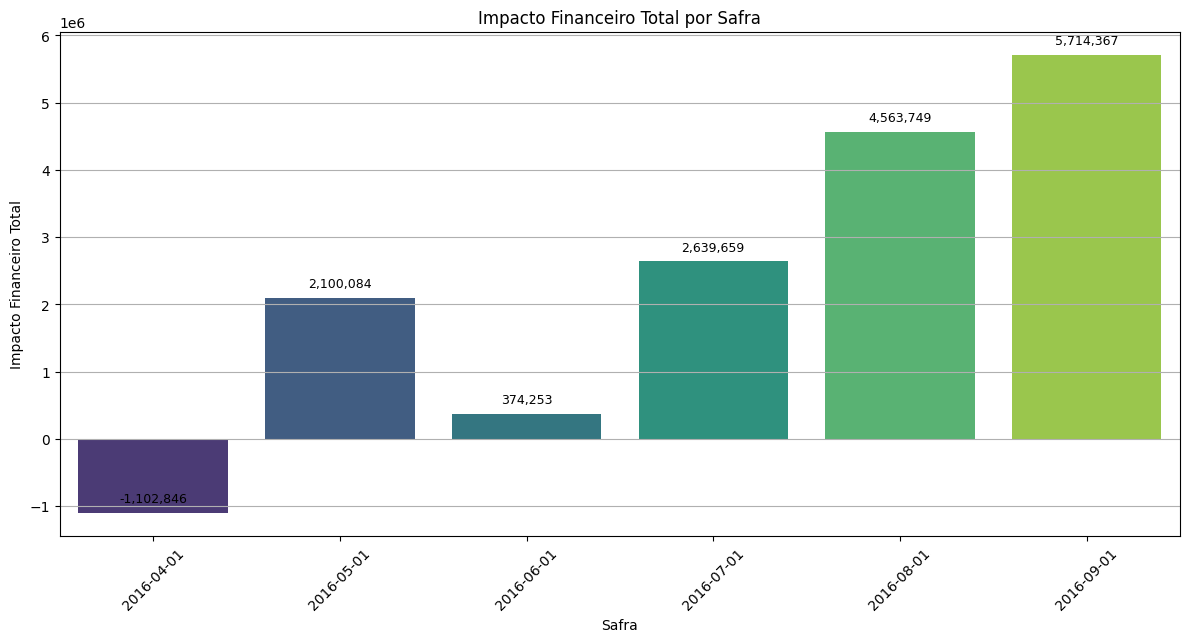

In [14]:
base['safra'] = pd.to_datetime(base['safra'])

# Calcular o total de impacto financeiro por safra
impacto_por_safra = base.groupby('safra')['impacto_financeiro'].sum().reset_index()

# Plotar o gráfico
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=impacto_por_safra, x='safra', y='impacto_financeiro', palette='viridis')

plt.xlabel('Safra')
plt.ylabel('Impacto Financeiro Total')
plt.title('Impacto Financeiro Total por Safra')
plt.grid(axis='y') # Adiciona grade no eixo y
plt.tight_layout()
plt.xticks(rotation=45) # Rotaciona os rótulos do eixo x para melhor visualização

# Adicionar rótulos nas barras (opcional, mas ajuda a ler os valores exatos)
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', # Formata o valor sem casas decimais e com separador de milhares
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points', fontsize=9)


plt.show()

In [15]:
scored_data_df.to_csv('/content/drive/MyDrive/Data Master/base_escorada_churn.csv')

# **Análise não supervisionada**

Analise não supervisionada para compreensão das caracteristicas dos clientes da plataforma.

In [16]:
base = pd.read_csv('/content/drive/MyDrive/Data Master/base_escorada_churn.csv')
train = base[base['base']=='train']
valid = base[base['base']=='valid']
test = base[base['base']=='test']
oot = base[base['base']=='oot']

**Clusterização dos clientes**

Para compreender o perfil dos clientes classificados no modelo, opta-se por criar um modelo de clusterização usando k-means clustering, agrupando os clientes com perfis diferentes e analisando seu comportamento.

Análise do perfil:
- Como ele consome a plataforma? -> tempo e quantidade de tempo escutado
- Quanto paga pelo servico de assinatura? Por quanto tempo ainda tem assinatura valida até o proximo pagamento?
- A quanto tempo começou a utilizar a plataforma?
- Qual idade desse cliente?

In [17]:
base.head()

,Unnamed: 0,msno,city,bd,gender,registered_via,safra,target,is_auto_renew,payment_plan_days,plan_list_price,actual_amount_paid,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,tempo_expiracao,tempo_iniciacao,city_te,gender_te,registered_via_te,is_auto_renew_te,is_cancel_te,base,proba,prediction,verdadeiro_churn,falso_churn,impacto_financeiro
0,0,zp1fkpGmGRdHidzu0rARjtQmrBCazmHEOLdck5wMp3o=,1.0,17.0,sem_registro,7.0,2016-05-01,0.0,1.0,30.0,99.0,99.0,0.0,114.528787,28.740476,18.008591,20.255956,536.278642,526.428807,141709.311191,34.0,271.0,0.080929,0.083455,0.041510,0.043341,0.071697,train,0.011120,0,False,False,0.0
1,1,YnQUHn4iid3ntFGo9drmZUgHOBtqE4W2wyMbQ5EPXyA=,13.0,29.0,female,7.0,2016-04-01,0.0,1.0,30.0,149.0,149.0,0.0,283.000000,62.000000,41.000000,45.000000,3577.200000,2865.000000,900460.786800,44.0,1387.0,0.137147,0.146753,0.041510,0.043341,0.071697,train,0.091135,0,False,False,0.0
2,2,NpidcMRW6UP/Y+CtsmwQ2EeHlOnH8uNrhjPo4hfhy0I=,13.0,25.0,female,7.0,2016-05-01,0.0,1.0,30.0,129.0,129.0,1.0,138.000000,44.000000,24.000000,19.000000,1229.000000,1322.000000,300332.541000,19.0,696.0,0.137147,0.146753,0.041510,0.043341,0.683012,train,0.835396,1,False,True,-387.0
3,3,/lWUM1gUbQNqgALnmbRRLiuQxuwdKO68f3Sx0tauoLU=,1.0,17.0,sem_registro,7.0,2016-08-01,0.0,1.0,30.0,149.0,149.0,0.0,58.000000,27.000000,20.000000,11.000000,1108.000000,483.000000,243377.255000,40.0,933.0,0.080929,0.083455,0.041510,0.043341,0.071697,train,0.244264,0,False,False,0.0
4,4,Z7wUDfcT+/Ru/kYR3b3ajGHQXBEubfKjWGpvaY3nvL0=,8.0,26.0,male,9.0,2016-06-01,0.0,1.0,30.0,149.0,149.0,0.0,33.000000,15.000000,10.000000,18.000000,919.000000,924.000000,240312.504000,52.0,1986.0,0.140472,0.146235,0.156402,0.043341,0.071697,train,0.291742,0,False,False,0.0


In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Variaveis selecionadas
cols = ['bd','actual_amount_paid', 'num_25', 'num_50',	'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs', 'tempo_expiracao', 'tempo_iniciacao']
X_train = train[cols]
X_valid = valid[cols]
X_test = test[cols]
X_oot = oot[cols]
X_completo=base[cols]

# Criar o pipeline: Escalonamento + PCA
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Primeiro, escalar os dados
    ('pca', PCA(n_components=2))    # Depois, aplicar PCA para 2 componentes
])

# Ajustar o pipeline nos dados selecionados
X_train_pca = pca_pipeline.fit_transform(X_train)
X_valid_pca = pca_pipeline.transform(X_valid)
X_test_pca = pca_pipeline.transform(X_test)
X_oot_pca = pca_pipeline.transform(X_oot)
X_base_pca = pca_pipeline.transform(X_completo)

# Criar um DataFrame com os componentes principais
pca_cols = [f'pca_component_{i+1}' for i in range(pca_pipeline.named_steps["pca"].n_components)]
X_train = pd.concat([X_train.reset_index(drop=True), pd.DataFrame(X_train_pca, columns=pca_cols)], axis=1)

print("Dataframe com componentes PCA:")
X_train.head()

Dataframe com componentes PCA:


,bd,actual_amount_paid,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,tempo_expiracao,tempo_iniciacao,pca_component_1,pca_component_2
0,17.0,99.0,114.528787,28.740476,18.008591,20.255956,536.278642,526.428807,141709.311191,34.0,271.0,-0.011691,-1.283976
1,29.0,149.0,283.000000,62.000000,41.000000,45.000000,3577.200000,2865.000000,900460.786800,44.0,1387.0,7.100234,2.124009
2,25.0,129.0,138.000000,44.000000,24.000000,19.000000,1229.000000,1322.000000,300332.541000,19.0,696.0,1.715574,-0.300004
3,17.0,149.0,58.000000,27.000000,20.000000,11.000000,1108.000000,483.000000,243377.255000,40.0,933.0,0.261628,-0.354462
4,26.0,149.0,33.000000,15.000000,10.000000,18.000000,919.000000,924.000000,240312.504000,52.0,1986.0,0.247788,1.104968


Text(0, 0.5, 'SSE')

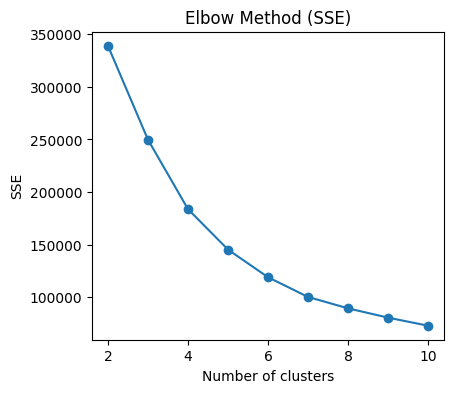

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pickle

# # Variaveis selecionadas
# cols = ['bd','actual_amount_paid', 'num_25', 'num_50',	'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs', 'tempo_expiracao', 'tempo_iniciacao']
# X = base[cols]

# # Padronize as variáveis
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Encontrar o melhor número de clusters (Elbow e Silhouette)
sse = []
# sil = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_train_pca)
    sse.append(kmeans.inertia_)
    # sil.append(silhouette_score(X_train_pca, labels))

# Plot Elbow Method
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(K_range, sse, marker='o')
plt.title('Elbow Method (SSE)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

# # Plot Silhouette Score
# plt.subplot(1, 2, 2)
# plt.plot(K_range, sil, marker='o')
# plt.title('Silhouette Score')
# plt.xlabel('Number of clusters')
# plt.ylabel('Silhouette')
# plt.tight_layout()
# plt.show()

In [28]:
# Escolha do melhor número de clusters
best_k = 6

# Treinando o modelo final
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_train_pca)
cluster_test = kmeans.predict(X_test_pca)
cluster_valid = kmeans.predict(X_valid_pca)
cluster_oot = kmeans.predict(X_oot_pca)
cluster_base = kmeans.predict(X_base_pca)

# Adicionando o cluster ao DataFrame original
train['cluster'] = cluster_labels
valid['cluster'] = cluster_valid
test['cluster'] = cluster_test
oot['cluster'] = cluster_oot
base['cluster'] = cluster_base

# Avaliando o resultado
print('Silhouette Score final:', silhouette_score(X_train, cluster_labels))
print(base.groupby('cluster')[cols].mean())  # perfil médio dos clusters

# Salvando o modelo e o pca usando pickle (pkl)
with open('pca_pipeline.pkl', 'wb') as f:
    pickle.dump(pca_pipeline, f)
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

Silhouette Score final: 0.07507612611215451
                bd  actual_amount_paid      num_25      num_50     num_75  \
cluster                                                                     
0        20.880035          279.031800  299.052586   73.462040  45.342142   
1        34.371591          436.520473   55.164646   14.016013   9.126144   
2        23.104451          347.307819  484.842917  123.567901  77.254548   
3        19.921888          228.100930  124.874135   31.487024  19.700169   
4        19.382694          178.065492   30.154753    7.800072   4.846341   
5        30.907125          467.155779  153.152019   40.174568  27.158858   

           num_985      num_100      num_unq     total_secs  tempo_expiracao  \
cluster                                                                        
0        48.231928   862.054805   999.468428  238481.493562        47.041392   
1        10.025276   358.737212   329.755510   93608.256607        58.195247   
2        85.363548 

## **Análise dos clusters**
1) Análise de clientes com diferentes perfis de uso da plataforma com as variadas estimações de churn

2) Análise de perfis de clientes com diferentes volatilidades/incertezas nas rspostas de churn

3) Análise de erros sistemáticos cometidos pelos modelos do case supervisionado

4) Análise de variação temporal no comportamento dos clientes de base


Percentual de Churn por Cluster:
   cluster  percentual_churn
0        0              9.19
1        1             13.83
2        2              9.00
3        3             11.34
4        4             12.16
5        5             10.72


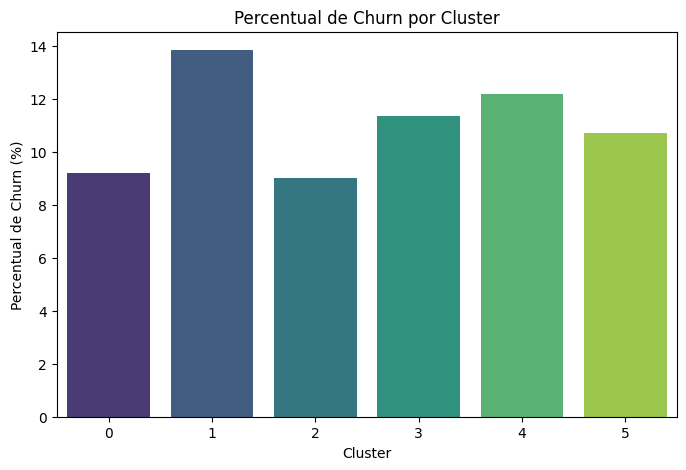

In [29]:
# Analisando a relação entre clusters e churn
churn_by_cluster = base.groupby('cluster')['target'].mean().reset_index()
churn_by_cluster.columns = ['cluster', 'percentual_churn']
churn_by_cluster['percentual_churn'] = round(churn_by_cluster['percentual_churn'] * 100, 2)

print("\nPercentual de Churn por Cluster:")
print(churn_by_cluster)

plt.figure(figsize=(8, 5))
sns.barplot(data=churn_by_cluster, x='cluster', y='percentual_churn', palette='viridis')
plt.title('Percentual de Churn por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentual de Churn (%)')
plt.show()

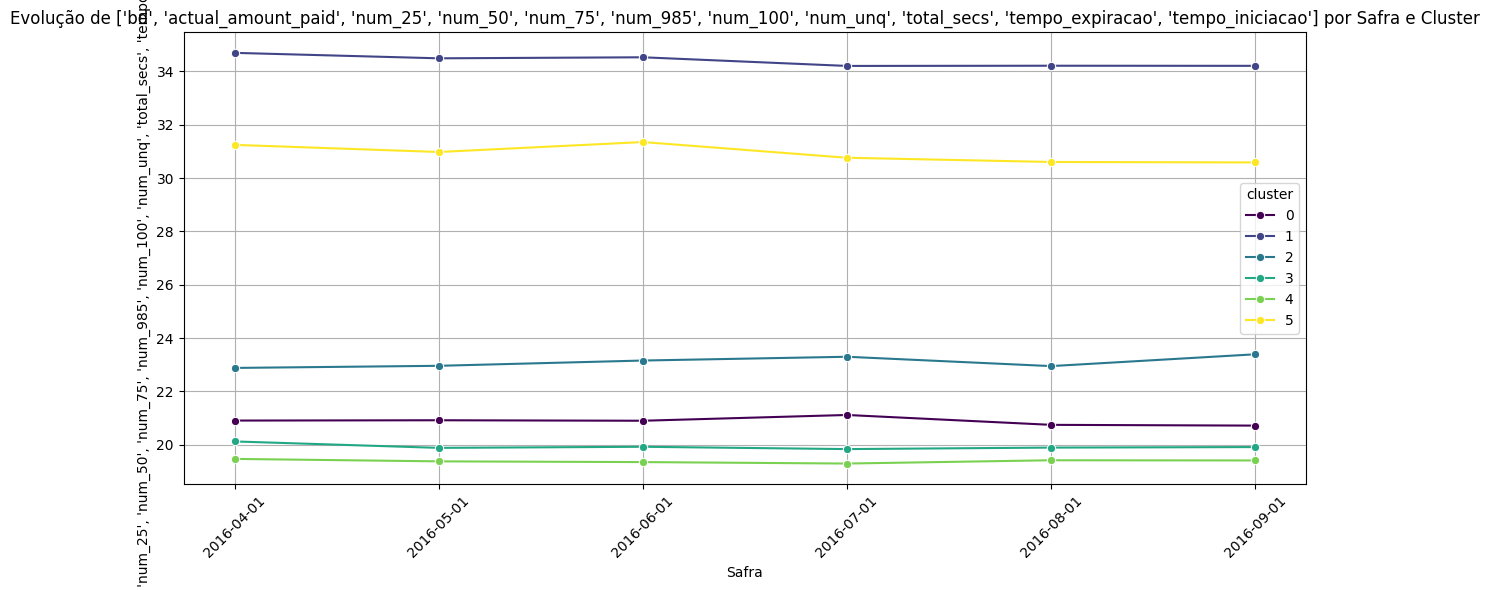

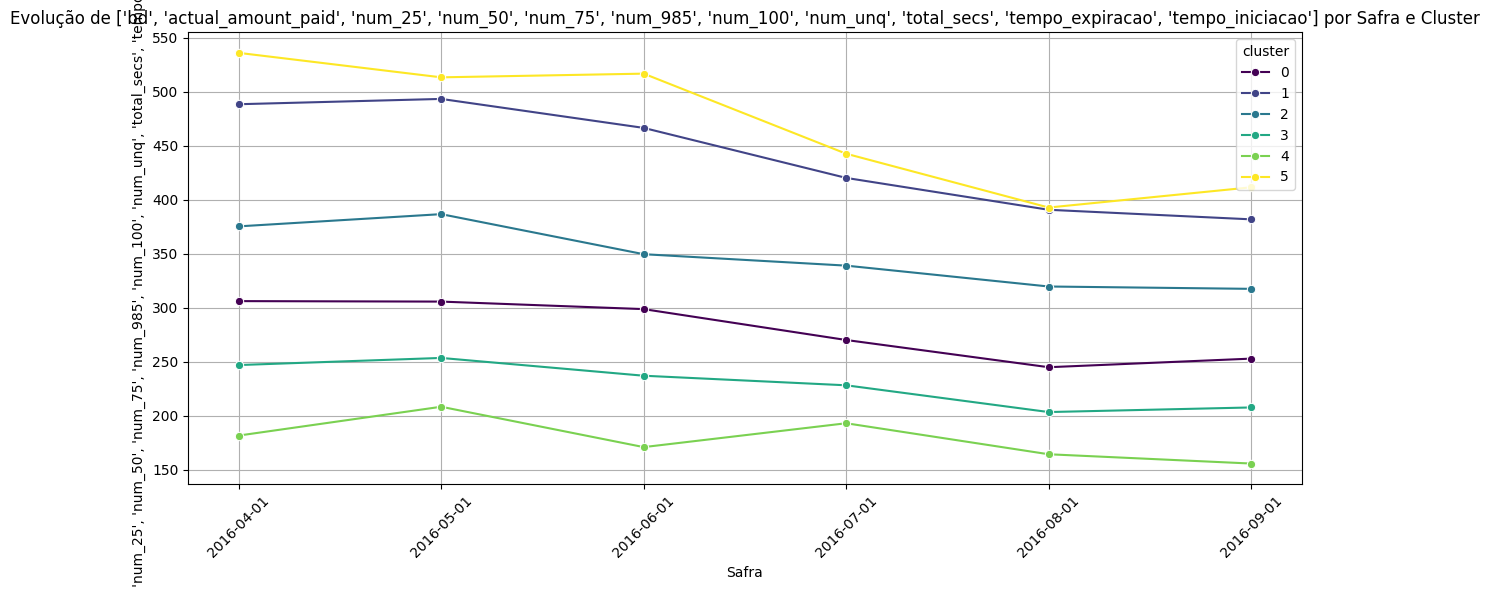

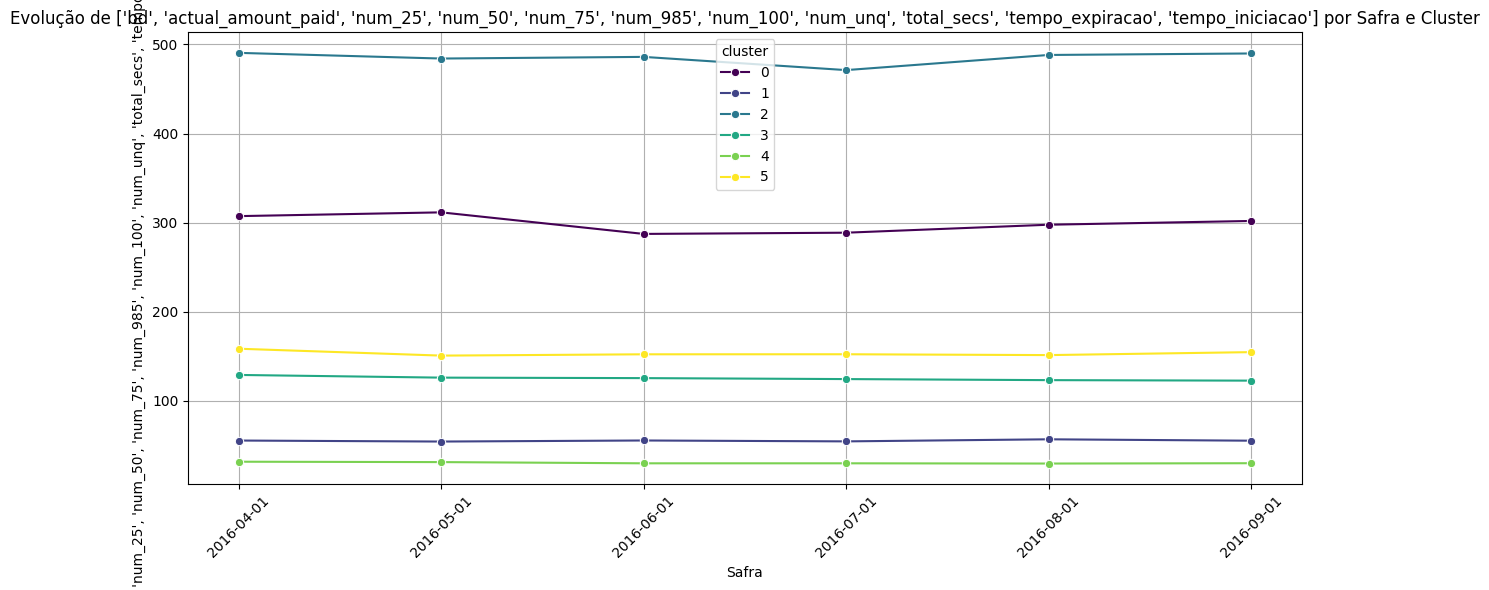

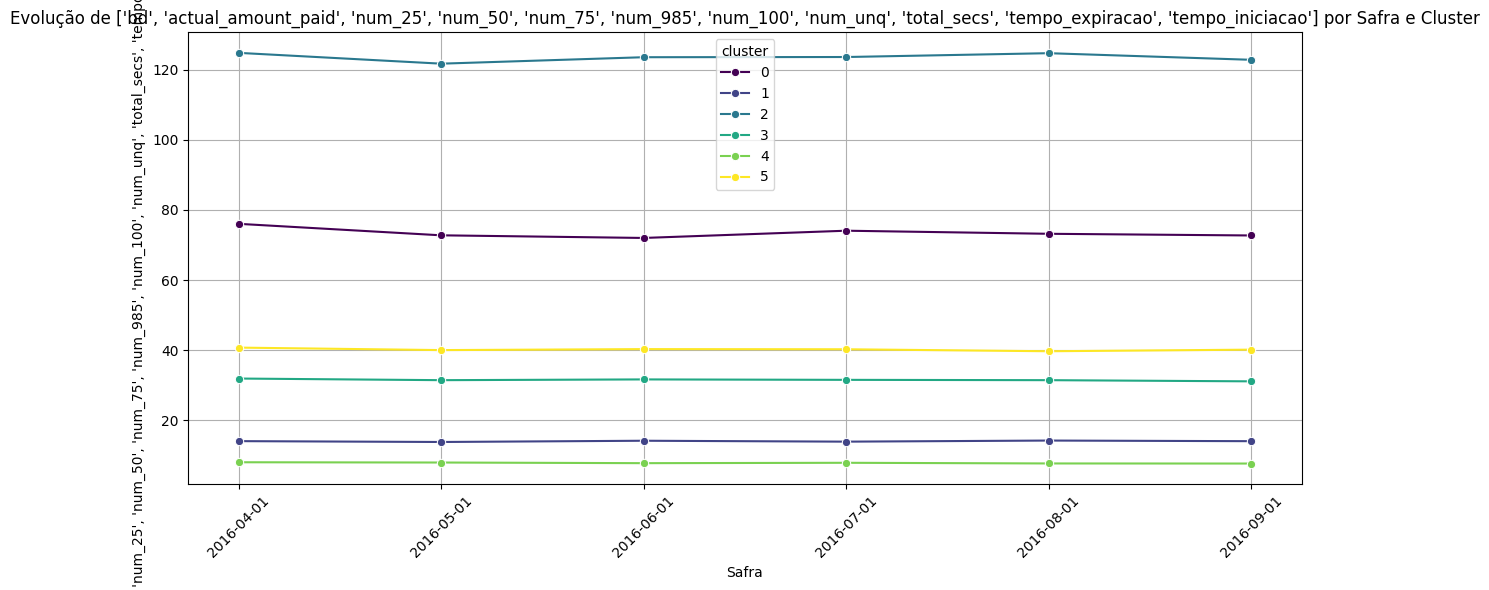

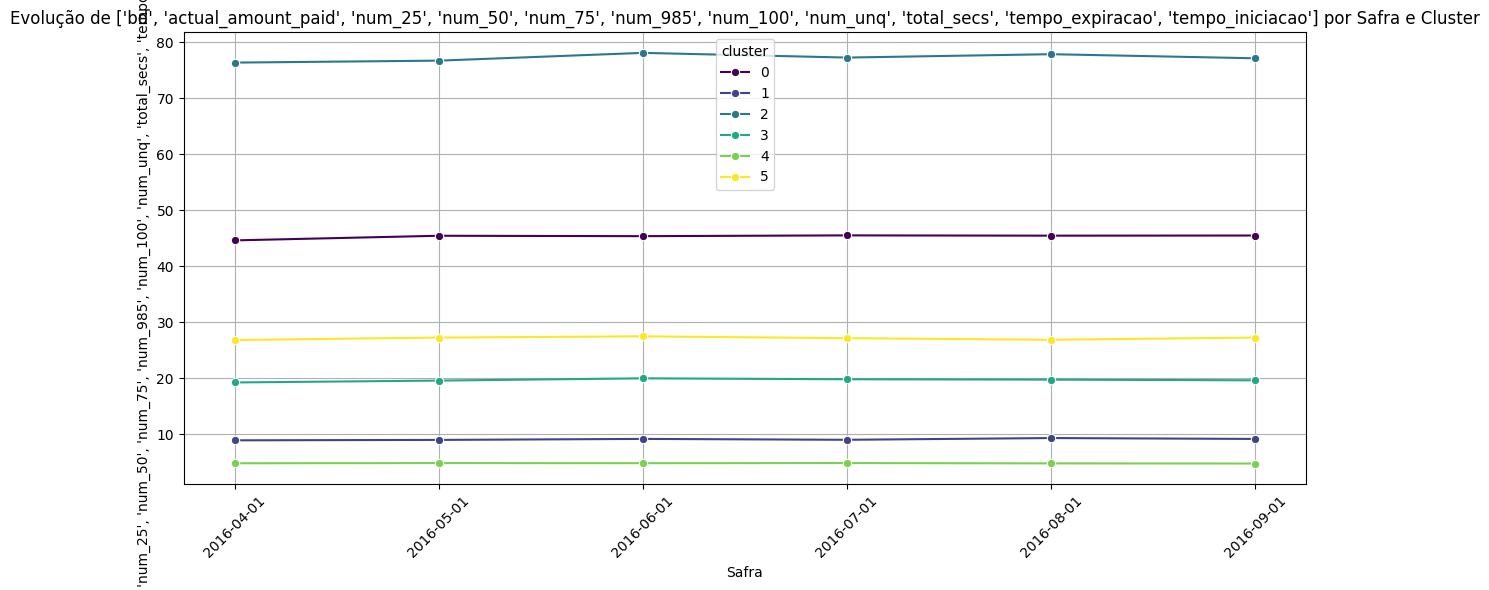

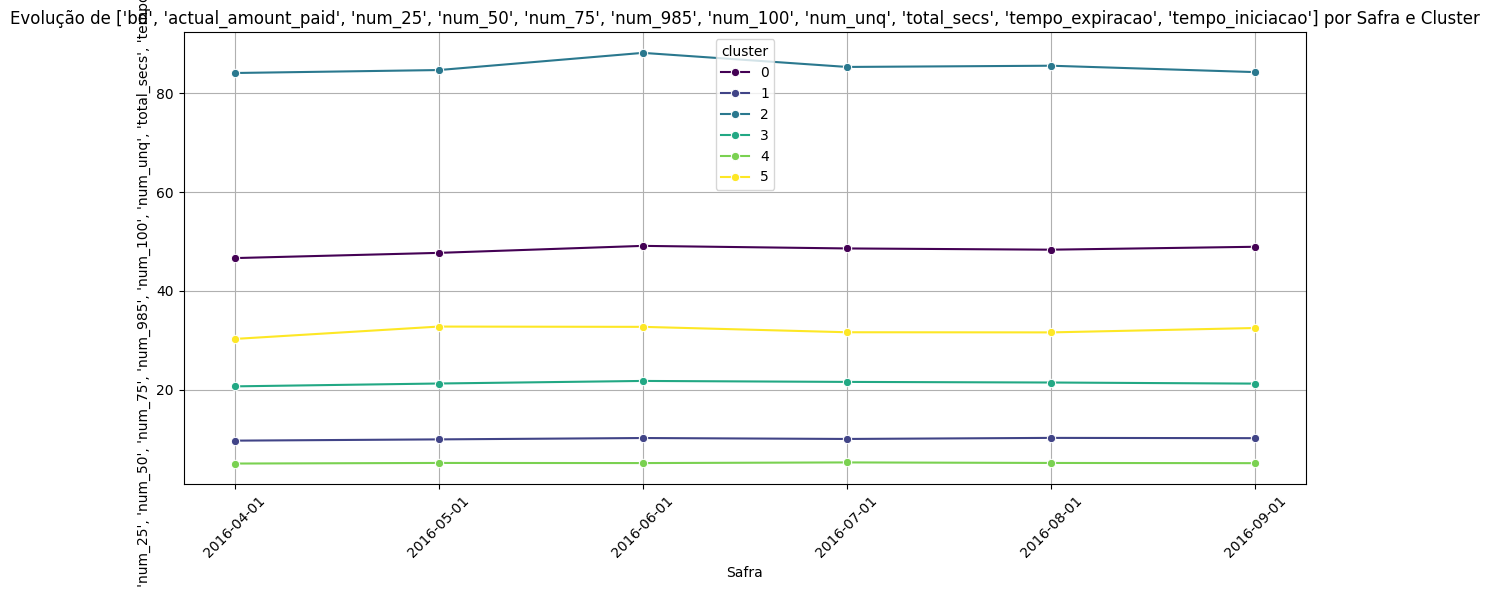

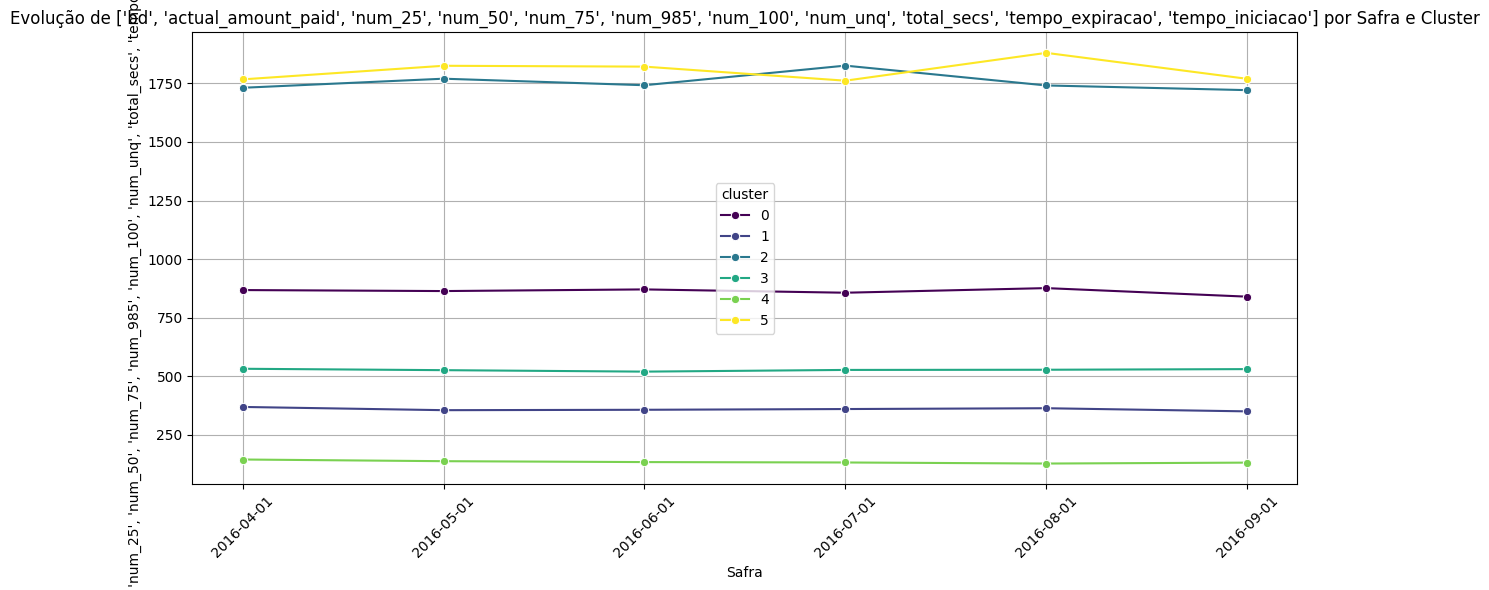

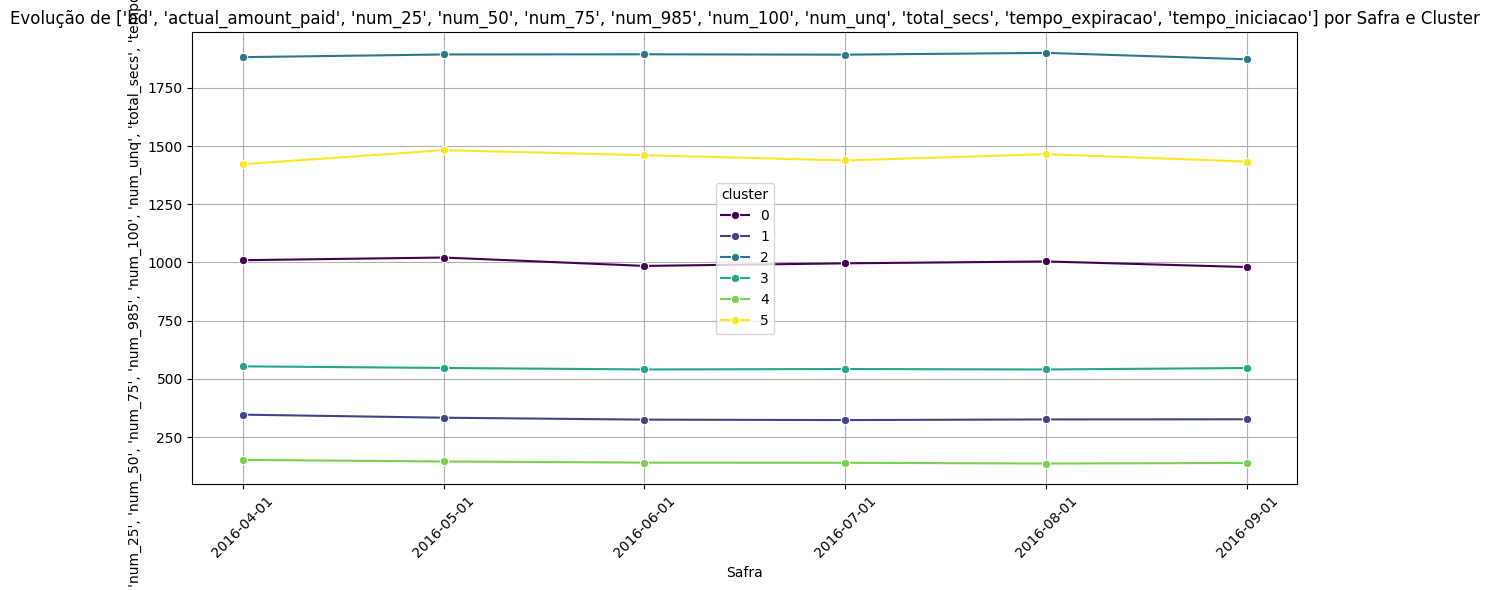

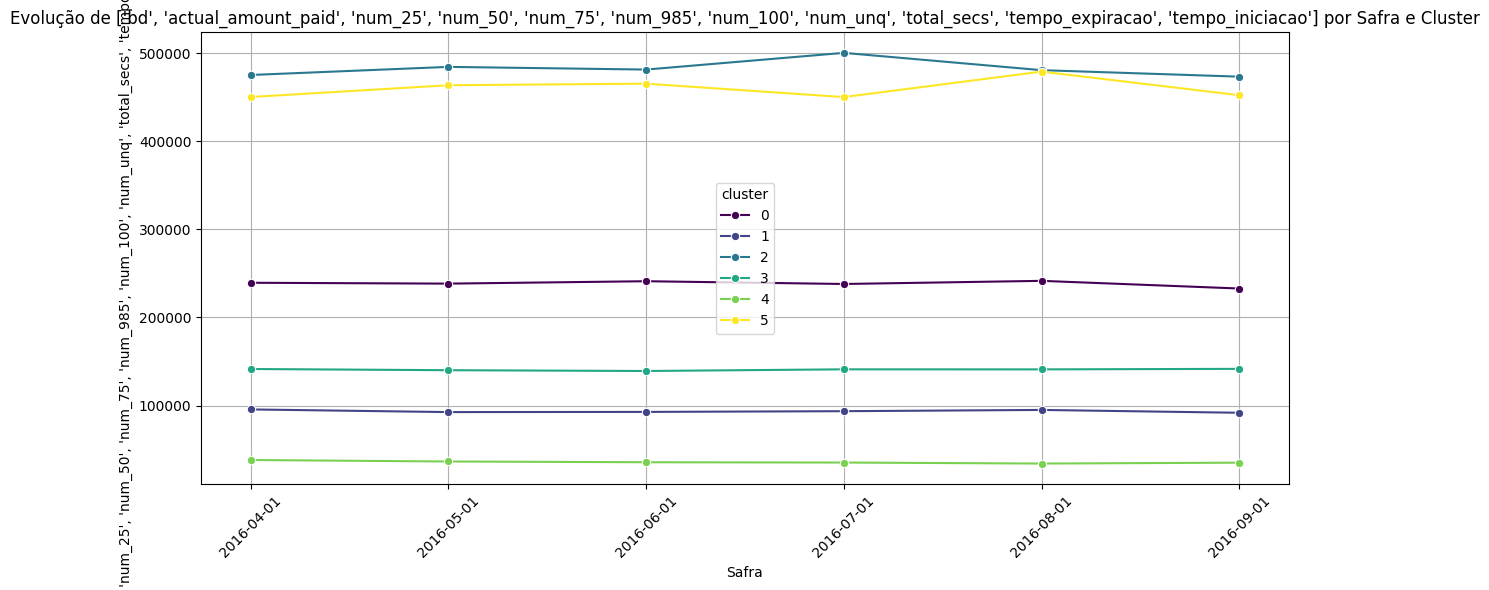

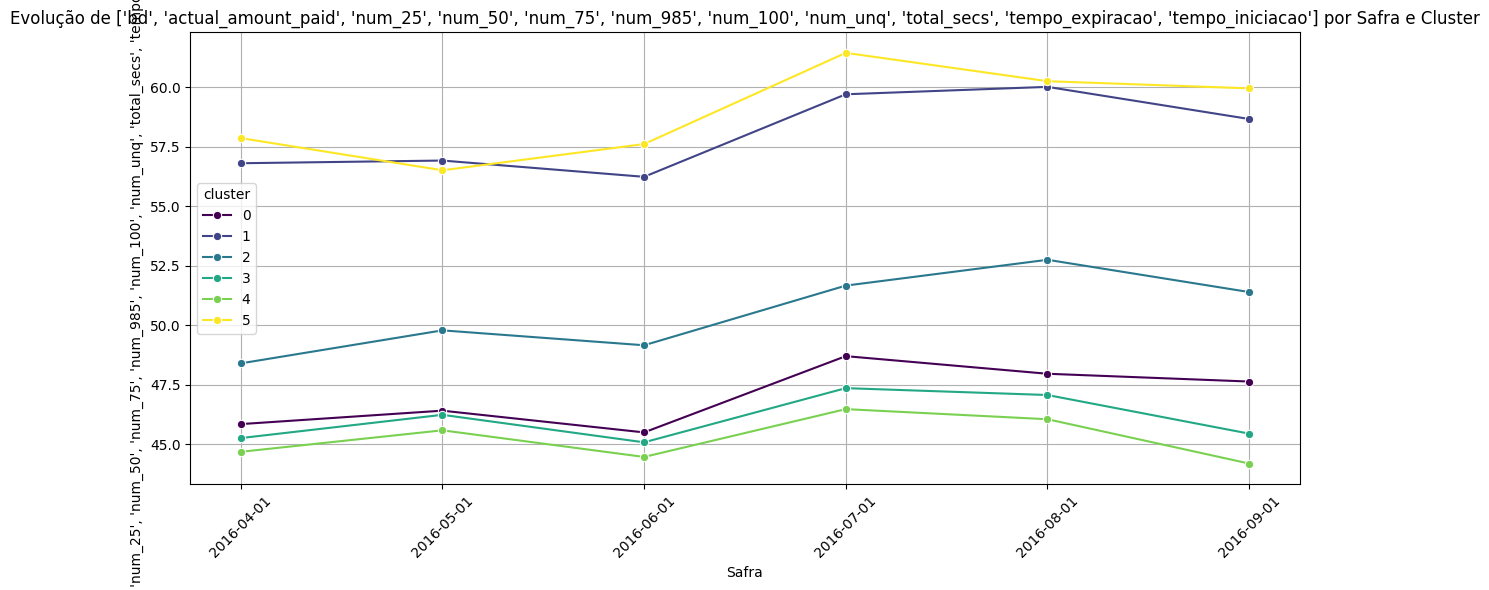

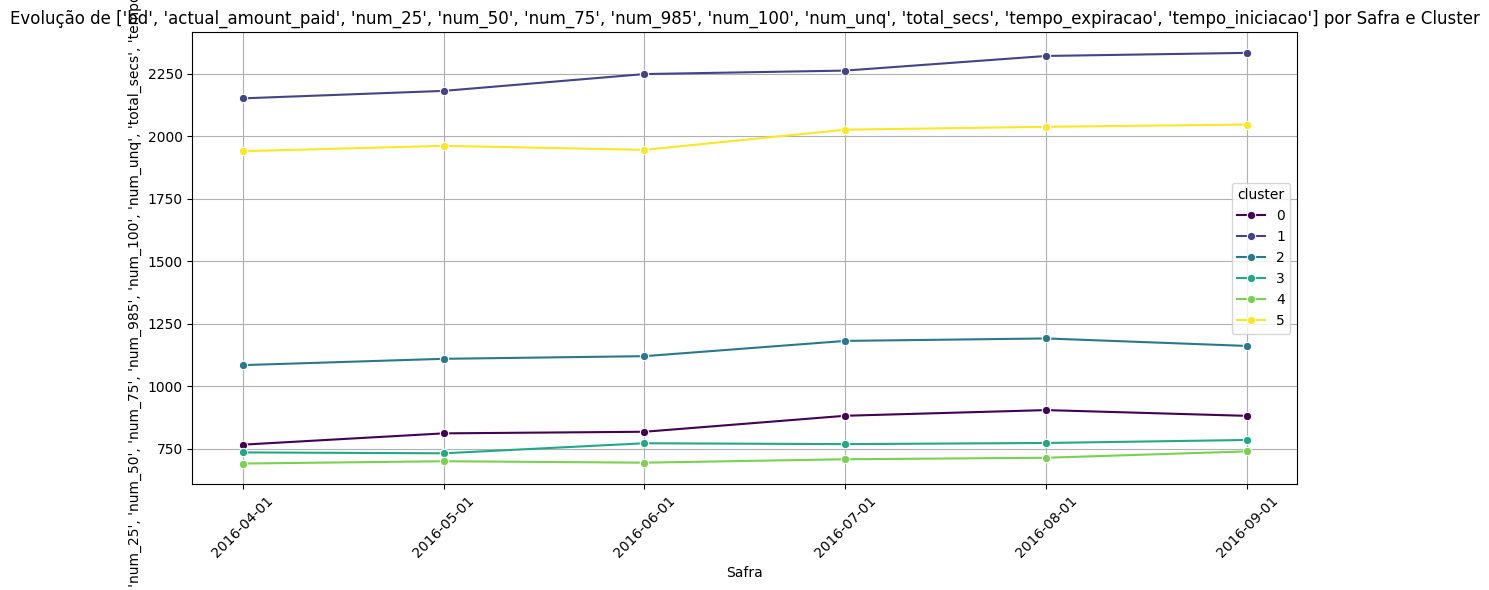

In [31]:
# Análise do perfil dos clusters em relação às variáveis originais (além da média geral)
# Agrupar pela safra e cluster e calcular a média das variáveis de perfil
profile_by_cluster_safra = base.groupby(['safra', 'cluster'])[cols].mean().reset_index()

for i in cols:
  plt.figure(figsize=(12, 6))
  sns.lineplot(data=profile_by_cluster_safra, x='safra', y=i, hue='cluster', marker='o', palette='viridis')
  plt.title(f'Evolução de {cols} por Safra e Cluster')
  plt.xlabel('Safra')
  plt.ylabel(f'{cols} Médio')
  plt.xticks(rotation=45)
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [32]:
# Análise dos clientes com maior volatilidade/incerteza nas respostas de churn (baseado na probabilidade)
# Clientes próximos ao threshold de classificação (e.g., 0.5 ou o threshold ótimo encontrado) podem ser considerados mais incertos.
# Vamos analisar os clientes com probabilidade entre (threshold - epsilon) e (threshold + epsilon)
optimal_threshold = 0.7 # Substituir pelo best_threshold encontrado anteriormente
epsilon = 0.1 # Define a faixa de incerteza

uncertain_clients = base[(base['proba'] >= (optimal_threshold - epsilon)) & (base['proba'] <= (optimal_threshold + epsilon))]

print(f"\nAnálise de Clientes Incertos (Proba entre {optimal_threshold - epsilon:.2f} e {optimal_threshold + epsilon:.2f}):")
print(uncertain_clients.groupby('cluster').size().reset_index(name='count'))
print(uncertain_clients[cols].mean()) # Perfil médio dos clientes incertos



Análise de Clientes Incertos (Proba entre 0.60 e 0.80):
   cluster  count
0        0   4716
1        1  12540
2        2   2309
3        3  10091
4        4   7168
5        5   4158
bd                        25.577180
actual_amount_paid       736.840666
num_25                   134.314752
num_50                    34.547726
num_75                    21.454833
num_985                   23.289319
num_100                  621.115143
num_unq                  628.660216
total_secs            165675.004769
tempo_expiracao           48.034492
tempo_iniciacao         1199.340589
dtype: float64


In [33]:
# Análise de erros sistemáticos do modelo supervisionado por cluster
# Falsos Positivos (FP): Modelo previu churn (prediction=1), mas não foi (target=0)
# Falsos Negativos (FN): Modelo previu não-churn (prediction=0), mas foi churn (target=1)

fp_clients = base[(base['target'] == 0) & (base['prediction'] == 1)]
fn_clients = base[(base['target'] == 1) & (base['prediction'] == 0)]

print("\nAnálise de Falsos Positivos por Cluster:")
print(fp_clients.groupby('cluster').size().reset_index(name='count'))
print(fp_clients[cols].mean()) # Perfil médio dos Falsos Positivos

print("\nAnálise de Falsos Negativos por Cluster:")
print(fn_clients.groupby('cluster').size().reset_index(name='count'))
print(fn_clients[cols].mean()) # Perfil médio dos Falsos Negativos



Análise de Falsos Positivos por Cluster:
   cluster  count
0        0   3847
1        1   9090
2        2   1929
3        3   7775
4        4   5254
5        5   3254
bd                        25.527144
actual_amount_paid       702.394971
num_25                   140.274649
num_50                    35.918041
num_75                    22.274037
num_985                   24.153367
num_100                  647.591855
num_unq                  653.013152
total_secs            172726.783237
tempo_expiracao           47.366977
tempo_iniciacao         1176.915503
dtype: float64

Análise de Falsos Negativos por Cluster:
   cluster  count
0        0    275
1        1    713
2        2    102
3        3   1077
4        4   1323
5        5    141
bd                        24.450840
actual_amount_paid       145.408703
num_25                    99.631355
num_50                    25.401740
num_75                    16.054066
num_985                   17.623104
num_100                  453.505888
n

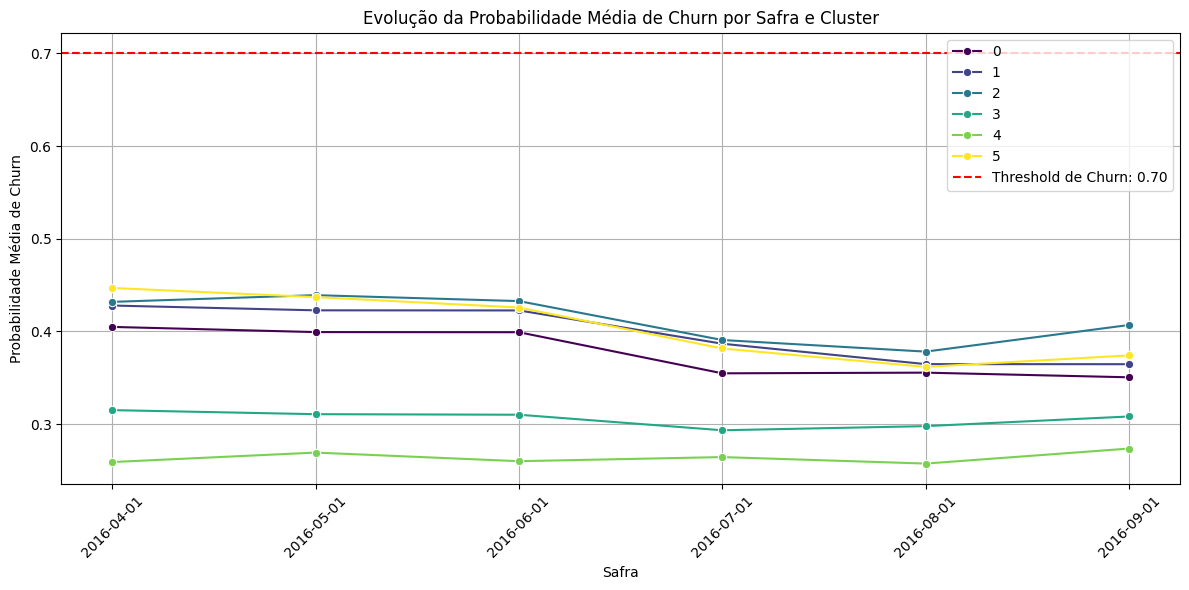

In [35]:
# Variação temporal no comportamento dos clientes de base (já abordado na análise da evolução por safra e cluster)
# O `profile_by_cluster_safra` DataFrame e os gráficos gerados já mostram essa variação temporal.

# Análise das Probabilidades de Churn por Cluster ao longo do Tempo (Safra)
proba_by_cluster_safra = base.groupby(['safra', 'cluster'])['proba'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=proba_by_cluster_safra, x='safra', y='proba', hue='cluster', marker='o', palette='viridis')
plt.axhline(optimal_threshold, color='red', linestyle='--', label=f'Threshold de Churn: {optimal_threshold:.2f}')
plt.title('Evolução da Probabilidade Média de Churn por Safra e Cluster')
plt.xlabel('Safra')
plt.ylabel('Probabilidade Média de Churn')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [36]:

# Resumo qualitativo dos Clusters
print("\nSumário Qualitativo dos Clusters:")
print("Cluster 0:")
print(base[base['cluster']==0][cols].mean())
print(f"Percentual de Churn: {churn_by_cluster[churn_by_cluster['cluster']==0]['percentual_churn'].iloc[0]}%")

print("\nCluster 1:")
print(base[base['cluster']==1][cols].mean())
print(f"Percentual de Churn: {churn_by_cluster[churn_by_cluster['cluster']==1]['percentual_churn'].iloc[0]}%")

print("\nCluster 2:")
print(base[base['cluster']==2][cols].mean())
print(f"Percentual de Churn: {churn_by_cluster[churn_by_cluster['cluster']==2]['percentual_churn'].iloc[0]}%")

print("\nCluster 3:")
print(base[base['cluster']==3][cols].mean())
print(f"Percentual de Churn: {churn_by_cluster[churn_by_cluster['cluster']==3]['percentual_churn'].iloc[0]}%")

print("\nCluster 4:")
print(base[base['cluster']==4][cols].mean())
print(f"Percentual de Churn: {churn_by_cluster[churn_by_cluster['cluster']==4]['percentual_churn'].iloc[0]}%")

print("\nCluster 5:")
print(base[base['cluster']==5][cols].mean())
print(f"Percentual de Churn: {churn_by_cluster[churn_by_cluster['cluster']==4]['percentual_churn'].iloc[0]}%")


Sumário Qualitativo dos Clusters:
Cluster 0:
bd                        20.880035
actual_amount_paid       279.031800
num_25                   299.052586
num_50                    73.462040
num_75                    45.342142
num_985                   48.231928
num_100                  862.054805
num_unq                  999.468428
total_secs            238481.493562
tempo_expiracao           47.041392
tempo_iniciacao          845.452693
dtype: float64
Percentual de Churn: 9.19%

Cluster 1:
bd                       34.371591
actual_amount_paid      436.520473
num_25                   55.164646
num_50                   14.016013
num_75                    9.126144
num_985                  10.025276
num_100                 358.737212
num_unq                 329.755510
total_secs            93608.256607
tempo_expiracao          58.195247
tempo_iniciacao        2254.367157
dtype: float64
Percentual de Churn: 13.83%

Cluster 2:
bd                        23.104451
actual_amount_paid       347